## Присоеденяйся [ >> ссылка на конкурс <<](https://www.kaggle.com/t/bc7f47a90c7d4056803c71bd3c64a76c) 🥳 

In [230]:
%matplotlib inline

In [231]:
import pandas as pd
import numpy as np
np.random.seed(0)

import re
import sys
import math

from ml_metrics import rmsle, mae, rmse
from sklearn.model_selection import KFold, learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score

from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, RandomForestClassifier

import xgboost as xgb
import catboost as ctb

from datetime import datetime
from pandas_profiling import ProfileReport

import matplotlib.pyplot as plt
import matplotlib.text as plttxt
import seaborn as sns
plt.style.use('bmh')
sns.set(rc={'figure.figsize':(20,10)})



In [232]:
df_train = pd.read_hdf('../input/tram.train.h5')
df_test = pd.read_hdf('../input/tram.test.h5')

In [233]:
df = pd.concat([df_train, df_test])
df.shape

(308152, 11)

# На всякий случай создаем себе песочницу для игр с данными

In [234]:
my_train = df.copy()
my_train.info() #проверяем формат данных

<class 'pandas.core.frame.DataFrame'>
Int64Index: 308152 entries, 0 to 308145
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            308152 non-null  int64  
 1   delay         175986 non-null  float64
 2   datetime      308152 non-null  object 
 3   stop          308152 non-null  int64  
 4   stop_name     308152 non-null  object 
 5   number        308152 non-null  int64  
 6   direction     308152 non-null  object 
 7   planned_time  308152 non-null  object 
 8   vehicle_id    308152 non-null  float64
 9   trip_id       308152 non-null  int64  
 10  seq_num       305770 non-null  float64
dtypes: float64(3), int64(4), object(4)
memory usage: 28.2+ MB


In [235]:
# Для начала факторизируем данные 
my_train["trip_id_cat"] = my_train["trip_id"].factorize()[0]
my_train["vehicle_cat"] = my_train["vehicle_id"].factorize()[0]

my_train["stop_name_cat"] = my_train["stop_name"].factorize()[0]
my_train["direction_cat"] = my_train["direction"].factorize()[0]

feats = my_train.select_dtypes("number").columns
black_list = ["id", "delay"]
feats = [x for x in feats if x not in black_list]
feats

['stop',
 'number',
 'vehicle_id',
 'trip_id',
 'seq_num',
 'trip_id_cat',
 'vehicle_cat',
 'stop_name_cat',
 'direction_cat']

In [236]:
# my_train = my_train.sort_values(by=["trip_id", "planned_time"], axis=0, ascending=[True, True])
# my_train

# Исследуем данные

In [237]:
my_train["delay"].unique() # опоздания трамвая кратно 60 секунд. прогнозировать будем в минутах, с точностью до 60 секунд

array([   0.,   60.,  120.,  180.,  240.,  300.,  360.,  420.,  540.,
        480.,  600., 1140.,  660.,  720.,  780.,  840.,  960.,   nan])

In [238]:
my_train["number"].unique() # обнаружили 22 уникальных номера трамваев

array([22, 11,  8,  1, 24, 52, 13, 50, 14,  9,  5, 19, 18,  3,  4,  6, 10,
       20,  2, 44, 16, 21])

In [239]:
my_train["trip_id"].nunique() # обнаружили 10117 уникальных маршрутов трамваем trip_id

17657

Интересно, что если опоздание меньше 60 секунд, то **delay** округляется до 0
также если трамвай приходит раньше планового времени, то delay также округляется до 0
значит прогнозировать будем **real_delay** в секундах, а потом округлим кратно 60 в меньшую сторону. 
Отрицательния значениия обнулим 

### СТРАТЕГИЯ находим реальное значение **delay** в секундах через разницу **real_delay** = **datetime** - **planned_time** , прогнозируем **real_delay**, потом округляем вниз кратно минутам

In [240]:
# трансформируем колонки в формат datetime64
my_train["datetime"] = my_train["datetime"].astype("datetime64")
my_train["planned_time"] = my_train["planned_time"].astype("datetime64")

In [241]:
# теперь это нужно перевести в секунды
my_train["real_delay"] = (my_train["datetime"] - my_train["planned_time"]).dt.total_seconds()
my_train["real_delay"] 

0          47.0
1          48.0
2         -11.0
3          -9.0
4          52.0
          ...  
308141    115.0
308142     14.0
308143    104.0
308144    136.0
308145     31.0
Name: real_delay, Length: 308152, dtype: float64

In [242]:
my_train[["real_delay", "delay"]] #проверяем как опоздания выглядит на практике. 

,real_delay,delay
0,47.0,0.0
1,48.0,0.0
2,-11.0,0.0
3,-9.0,0.0
4,52.0,0.0
...,...,...
308141,115.0,NaN
308142,14.0,NaN
308143,104.0,NaN
308144,136.0,NaN


In [243]:
my_train[my_train["real_delay"] < 0] #real_delay < 0 на 0 (когда трамвай приехал раньше времени) 

,id,delay,datetime,stop,stop_name,number,direction,planned_time,vehicle_id,trip_id,seq_num,trip_id_cat,vehicle_cat,stop_name_cat,direction_cat,real_delay
2,2,0.0,2018-07-23 06:00:49,322,Filharmonia,8,Bronowice Małe,2018-07-23 06:01:00,6.352185e+18,6351558574044592386,15.0,2,1,2,2,-11.0
3,3,0.0,2018-07-23 06:00:51,363,Hala Targowa,1,Salwator,2018-07-23 06:01:00,6.352185e+18,6351558574044379394,24.0,3,0,3,3,-9.0
11,11,0.0,2018-07-23 06:00:59,112,Stella-Sawickiego,9,Nowy Bieżanów P+R,2018-07-23 06:01:00,6.352185e+18,6351558574044616962,14.0,11,0,11,7,-1.0
13,13,0.0,2018-07-23 06:00:59,407,Czyżyny,5,Wzgórza K.,2018-07-23 06:01:00,6.352185e+18,6351558574044498179,14.0,13,0,13,9,-1.0
23,23,0.0,2018-07-23 06:01:13,2608,Dworzec Główny Zachód,3,Krowodrza Górka,2018-07-23 06:02:00,6.352185e+18,6351558574044440835,19.0,23,1,22,6,-47.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
308094,308094,NaN,2018-07-31 23:44:38,569,Limanowskiego,13,Nowy Bieżanów P+R,2018-07-31 23:45:00,6.352185e+18,6351558574044700948,16.0,10115,1,128,7,-22.0
308105,308105,NaN,2018-07-31 23:46:44,3158,Podgórze SKA,13,Nowy Bieżanów P+R,2018-07-31 23:47:00,6.352185e+18,6351558574044700948,17.0,10115,1,70,7,-16.0
308134,308134,NaN,2018-07-31 23:53:51,2688,Norymberska,18,Czerwone Maki P+R,2018-07-31 23:54:00,6.352185e+18,6351558574044791061,22.0,17654,1,17,1,-9.0
308135,308135,NaN,2018-07-31 23:54:23,630,Bieżanowska,13,Nowy Bieżanów P+R,2018-07-31 23:55:00,6.352185e+18,6351558574044700948,21.0,10115,1,51,7,-37.0


In [244]:
# создаем доп признаки указывающие на то, опоздал поезд или приехал раньше
my_train["real_delay_is_pos"] = my_train["real_delay"].map(lambda x: True if x > 0 else False) 

In [245]:
# создаем доп признаки с весами опозданий в пропорции ко всем значениям (среднее)
my_train["is_delay_neg"] = my_train["delay"].map(lambda x: x if x <= 0 else 0) 
my_train["is_delay_pos"] = my_train["delay"].map(lambda x: x if x > 0 else 0) 

<AxesSubplot:>

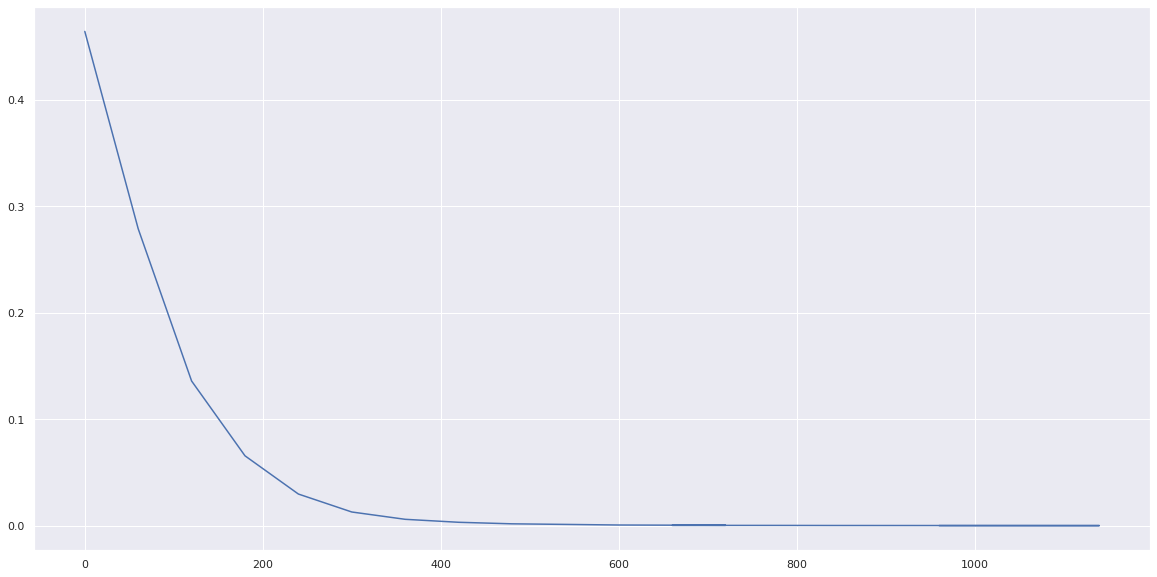

In [246]:
my_train["delay"].value_counts(normalize=True).plot() # проверяем, как опоздания выглядят на практике 

In [247]:
my_train.loc[my_train["delay"].notnull(), "group_delay"] = my_train.loc[my_train["delay"].notnull(),"delay"].map(lambda x: str(x) if x <=180 else "180+")

In [248]:
my_train["group_delay"].value_counts(normalize=True) # группируем все опоздания больше 180 секунд

0.0      0.464230
60.0     0.278829
120.0    0.135835
180.0    0.065551
180+     0.055556
Name: group_delay, dtype: float64

In [249]:
# заменяем все значения real_delay < 0 на 0 (когда трамвай приехал раньше времени)
# my_train["real_delay"] =  my_train["real_delay"].map(lambda x: 0 if x < 0 else x) 

In [250]:
#проверяем по скольким trip_id незаполненных данных колонке seq_num 
my_train[my_train["seq_num"].isnull()]["trip_id"].nunique() 

149

In [251]:
my_train[my_train["seq_num"].isnull()].number.unique() #проверяем по каким number есть пропущенные значения в seq_num 

array([44,  3, 21, 22,  4,  6])

In [252]:
my_train[my_train["seq_num"].isnull()] #проверяем по каким number есть пропущенные значения в seq_num 

,id,delay,datetime,stop,stop_name,number,direction,planned_time,vehicle_id,trip_id,seq_num,trip_id_cat,vehicle_cat,stop_name_cat,direction_cat,real_delay,real_delay_is_pos,is_delay_neg,is_delay_pos,group_delay
9945,9945,0.0,2018-07-23 09:25:32,1049,Głowackiego,44,Kombinat,2018-07-23 09:25:00,6.352185e+18,6351558574044981509,NaN,632,0,109,19,32.0,True,0.0,0.0,0.0
10097,10097,0.0,2018-07-23 09:28:38,84,Biprostal,44,Kombinat,2018-07-23 09:28:00,6.352185e+18,6351558574044981509,NaN,632,0,16,19,38.0,True,0.0,0.0,0.0
10142,10142,0.0,2018-07-23 09:29:36,83,Urzędnicza,44,Kombinat,2018-07-23 09:29:00,6.352185e+18,6351558574044981509,NaN,632,0,33,19,36.0,True,0.0,0.0,0.0
10456,10456,60.0,2018-07-23 09:35:59,77,Teatr Bagatela,44,Kombinat,2018-07-23 09:34:00,6.352185e+18,6351558574044981509,NaN,632,0,31,19,119.0,True,0.0,60.0,60.0
10546,10546,0.0,2018-07-23 09:37:50,3032,Stary Kleparz,44,Kombinat,2018-07-23 09:37:00,6.352185e+18,6351558574044981509,NaN,632,0,58,19,50.0,True,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307661,307661,NaN,2018-07-31 23:09:53,113,AWF,4,Kombinat,2018-07-31 23:07:00,6.352185e+18,6351558574044471567,NaN,17608,1,24,19,173.0,True,0.0,0.0,NaN
307699,307699,NaN,2018-07-31 23:12:08,407,Czyżyny,4,Kombinat,2018-07-31 23:09:00,6.352185e+18,6351558574044471567,NaN,17608,1,13,19,188.0,True,0.0,0.0,NaN
307735,307735,NaN,2018-07-31 23:13:52,408,Rondo Czyżyńskie,4,Kombinat,2018-07-31 23:12:00,6.352185e+18,6351558574044471567,NaN,17608,1,25,19,112.0,True,0.0,0.0,NaN
307766,307766,NaN,2018-07-31 23:15:43,413,Os.Kolorowe,4,Kombinat,2018-07-31 23:13:00,6.352185e+18,6351558574044471567,NaN,17608,1,45,19,163.0,True,0.0,0.0,NaN


### Гипотеза 1 только направлени direction = 'Kombinat' не имеет seq_num, тогда его можно удалить

In [253]:
# проверяем во всем ли trip_id отсутствуют значения seq_num
x = my_train[my_train["seq_num"].isnull()]["trip_id"].unique()

my_train[my_train["trip_id"].isin(list(x))].direction.unique()

array(['Kombinat', 'Dworzec Tow.', 'Os.Piastów', 'Kurdwanów P+R'],
      dtype=object)

Гипотеза, что только direction = 'Kombinat' не имеет seq_num не подтвердилась. Копаем глубже

### Гипотеза 2 - в тех поездках, где отсутствует seq_num он (seq_num = NaN) для всей поездки trip_id.

In [254]:
mx = my_train[my_train["trip_id"].isin(list(x))]
mx.count()

id                   2387
delay                1339
datetime             2387
stop                 2387
stop_name            2387
number               2387
direction            2387
planned_time         2387
vehicle_id           2387
trip_id              2387
seq_num                 5
trip_id_cat          2387
vehicle_cat          2387
stop_name_cat        2387
direction_cat        2387
real_delay           2387
real_delay_is_pos    2387
is_delay_neg         2387
is_delay_pos         2387
group_delay          1339
dtype: int64

In [255]:
my_train[my_train["seq_num"].isnull()].count()

id                   2382
delay                1335
datetime             2382
stop                 2382
stop_name            2382
number               2382
direction            2382
planned_time         2382
vehicle_id           2382
trip_id              2382
seq_num                 0
trip_id_cat          2382
vehicle_cat          2382
stop_name_cat        2382
direction_cat        2382
real_delay           2382
real_delay_is_pos    2382
is_delay_neg         2382
is_delay_pos         2382
group_delay          1335
dtype: int64

In [256]:
mx[mx["seq_num"].notnull()]

,id,delay,datetime,stop,stop_name,number,direction,planned_time,vehicle_id,trip_id,seq_num,trip_id_cat,vehicle_cat,stop_name_cat,direction_cat,real_delay,real_delay_is_pos,is_delay_neg,is_delay_pos,group_delay
16918,16918,60.0,2018-07-23 11:58:27,382,Kleeberga,21,Os.Piastów,2018-07-23 11:57:00,6.352185e+18,6351558574045092105,10.0,967,0,86,4,87.0,True,0.0,60.0,60.0
16961,16961,60.0,2018-07-23 11:59:34,379,Piasta Kołodzieja,21,Os.Piastów,2018-07-23 11:58:00,6.352185e+18,6351558574045092105,11.0,967,0,62,4,94.0,True,0.0,60.0,60.0
180116,180116,0.0,2018-07-27 04:54:37,624,Kabel,6,Kurdwanów P+R,2018-07-27 04:54:00,6.352185e+18,6351558574046350593,15.0,5024,0,91,12,37.0,True,0.0,0.0,0.0
180171,180171,60.0,2018-07-27 04:58:37,630,Bieżanowska,6,Kurdwanów P+R,2018-07-27 04:57:00,6.352185e+18,6351558574046350593,16.0,5024,0,51,12,97.0,True,0.0,60.0,60.0
264762,264762,NaN,2018-07-31 04:57:11,630,Bieżanowska,6,Kurdwanów P+R,2018-07-31 04:57:00,6.352185e+18,6351558574044508417,16.0,15080,0,51,12,11.0,True,0.0,0.0,NaN


In [257]:
mx[mx["trip_id"] == 6351558574045092105]

,id,delay,datetime,stop,stop_name,number,direction,planned_time,vehicle_id,trip_id,seq_num,trip_id_cat,vehicle_cat,stop_name_cat,direction_cat,real_delay,real_delay_is_pos,is_delay_neg,is_delay_pos,group_delay
16645,16645,0.0,2018-07-23 11:52:14,375,Mistrzejowice,21,Os.Piastów,2018-07-23 11:52:00,6.352185e+18,6351558574045092105,NaN,967,0,141,4,14.0,True,0.0,0.0,0.0
16918,16918,60.0,2018-07-23 11:58:27,382,Kleeberga,21,Os.Piastów,2018-07-23 11:57:00,6.352185e+18,6351558574045092105,10.0,967,0,86,4,87.0,True,0.0,60.0,60.0
16961,16961,60.0,2018-07-23 11:59:34,379,Piasta Kołodzieja,21,Os.Piastów,2018-07-23 11:58:00,6.352185e+18,6351558574045092105,11.0,967,0,62,4,94.0,True,0.0,60.0,60.0


In [258]:
mx[mx["trip_id"] == 6351558574044508417]

,id,delay,datetime,stop,stop_name,number,direction,planned_time,vehicle_id,trip_id,seq_num,trip_id_cat,vehicle_cat,stop_name_cat,direction_cat,real_delay,real_delay_is_pos,is_delay_neg,is_delay_pos,group_delay
264508,264508,NaN,2018-07-31 04:14:55,459,Kombinat,6,Kurdwanów P+R,2018-07-31 04:15:00,6.352185e+18,6351558574044508417,NaN,15080,0,98,12,-5.0,False,0.0,0.0,NaN
264514,264514,NaN,2018-07-31 04:20:26,423,Struga,6,Kurdwanów P+R,2018-07-31 04:21:00,6.352185e+18,6351558574044508417,NaN,15080,0,137,12,-34.0,False,0.0,0.0,NaN
264522,264522,NaN,2018-07-31 04:25:20,413,Os.Kolorowe,6,Kurdwanów P+R,2018-07-31 04:26:00,6.352185e+18,6351558574044508417,NaN,15080,0,45,12,-40.0,False,0.0,0.0,NaN
264526,264526,NaN,2018-07-31 04:28:16,408,Rondo Czyżyńskie,6,Kurdwanów P+R,2018-07-31 04:29:00,6.352185e+18,6351558574044508417,NaN,15080,0,25,12,-44.0,False,0.0,0.0,NaN
264534,264534,NaN,2018-07-31 04:31:33,3041,Rondo 308. Dywizjonu,6,Kurdwanów P+R,2018-07-31 04:31:00,6.352185e+18,6351558574044508417,NaN,15080,0,61,12,33.0,True,0.0,0.0,NaN
264540,264540,NaN,2018-07-31 04:33:02,930,M1 Al. Pokoju,6,Kurdwanów P+R,2018-07-31 04:33:00,6.352185e+18,6351558574044508417,NaN,15080,0,130,12,2.0,True,0.0,0.0,NaN
264546,264546,NaN,2018-07-31 04:34:10,2871,TAURON Arena Kraków Al. Pokoju,6,Kurdwanów P+R,2018-07-31 04:34:00,6.352185e+18,6351558574044508417,NaN,15080,0,126,12,10.0,True,0.0,0.0,NaN
264561,264561,NaN,2018-07-31 04:37:26,370,Dąbie,6,Kurdwanów P+R,2018-07-31 04:37:00,6.352185e+18,6351558574044508417,NaN,15080,0,108,12,26.0,True,0.0,0.0,NaN
264574,264574,NaN,2018-07-31 04:39:44,368,Fabryczna,6,Kurdwanów P+R,2018-07-31 04:39:00,6.352185e+18,6351558574044508417,NaN,15080,0,9,12,44.0,True,0.0,0.0,NaN
264583,264583,NaN,2018-07-31 04:40:29,367,Francesco Nullo,6,Kurdwanów P+R,2018-07-31 04:40:00,6.352185e+18,6351558574044508417,NaN,15080,0,72,12,29.0,True,0.0,0.0,NaN


In [259]:
mx[mx["trip_id"] == 6351558574046350593]

,id,delay,datetime,stop,stop_name,number,direction,planned_time,vehicle_id,trip_id,seq_num,trip_id_cat,vehicle_cat,stop_name_cat,direction_cat,real_delay,real_delay_is_pos,is_delay_neg,is_delay_pos,group_delay
179962,179962,60.0,2018-07-27 04:34:08,930,M1 Al. Pokoju,6,Kurdwanów P+R,2018-07-27 04:33:00,6.352185e+18,6351558574046350593,NaN,5024,0,130,12,68.0,True,0.0,60.0,60.0
179974,179974,0.0,2018-07-27 04:37:36,370,Dąbie,6,Kurdwanów P+R,2018-07-27 04:37:00,6.352185e+18,6351558574046350593,NaN,5024,0,108,12,36.0,True,0.0,0.0,0.0
179989,179989,0.0,2018-07-27 04:40:44,367,Francesco Nullo,6,Kurdwanów P+R,2018-07-27 04:40:00,6.352185e+18,6351558574046350593,NaN,5024,0,72,12,44.0,True,0.0,0.0,0.0
179996,179996,0.0,2018-07-27 04:41:55,2859,Teatr Variété,6,Kurdwanów P+R,2018-07-27 04:41:00,6.352185e+18,6351558574046350593,NaN,5024,0,93,12,55.0,True,0.0,0.0,0.0
180072,180072,0.0,2018-07-27 04:51:26,2870,Dworzec Płaszów Estakada,6,Kurdwanów P+R,2018-07-27 04:52:00,6.352185e+18,6351558574046350593,NaN,5024,0,113,12,-34.0,False,0.0,0.0,0.0
180116,180116,0.0,2018-07-27 04:54:37,624,Kabel,6,Kurdwanów P+R,2018-07-27 04:54:00,6.352185e+18,6351558574046350593,15.0,5024,0,91,12,37.0,True,0.0,0.0,0.0
180171,180171,60.0,2018-07-27 04:58:37,630,Bieżanowska,6,Kurdwanów P+R,2018-07-27 04:57:00,6.352185e+18,6351558574046350593,16.0,5024,0,51,12,97.0,True,0.0,60.0,60.0


Гипотеза 2 - в тех поездках, где отсутствует seq_num он (seq_num = NaN) для всей поездки trip_id 
подтвердилась почти полностью, с небольшим исключением, которым можно пренебречь.

Можно заменить все (seq_num = NaN) например 1, но стоит поискать вариант заполнения поинтараснее

In [260]:
# my_train["seq_num"] = my_train["seq_num"].fillna(1)

In [261]:
# заполняем пропуски в колонке seq_num 
# my_train["real_seq_num"] = my_train.groupby("trip_id").cumcount()

In [262]:
# заполняем пропуски, нумеруем последовательность остановок в пределах одного "trip_id"
my_train.loc[my_train["seq_num"].isnull(), "seq_num"] = my_train[my_train["seq_num"].isnull()].groupby("trip_id").cumcount()
my_train["real_seq_num"] = my_train.groupby("trip_id").cumcount()+1

In [263]:
my_train.loc[my_train["seq_num"].isnull(), "seq_num"] = my_train.loc[my_train["seq_num"].isnull(), "real_seq_num"]

In [264]:
# проверяем количество остановок по каждому маршруту
my_train.groupby("number").agg({"seq_num":max})

,seq_num
number,
1,31.0
2,11.0
3,23.0
4,32.0
5,25.0
6,21.0
8,26.0
9,35.0
10,27.0


In [265]:
my_train[(my_train["number"] == 52) & (my_train["direction"] == "Os.Piastów") & (my_train["trip_id"] == 6351558574045030659)]

,id,delay,datetime,stop,stop_name,number,direction,planned_time,vehicle_id,trip_id,...,trip_id_cat,vehicle_cat,stop_name_cat,direction_cat,real_delay,real_delay_is_pos,is_delay_neg,is_delay_pos,group_delay,real_seq_num
5,5,0.0,2018-07-23 06:00:53,131,Dworzec Główny,52,Os.Piastów,2018-07-23 06:00:00,6.352185e+18,6351558574045030659,...,5,1,5,4,53.0,True,0.0,0.0,0.0,1
83,83,0.0,2018-07-23 06:02:51,126,Lubicz,52,Os.Piastów,2018-07-23 06:02:00,6.352185e+18,6351558574045030659,...,5,1,64,4,51.0,True,0.0,0.0,0.0,2
206,206,60.0,2018-07-23 06:05:33,125,Rondo Mogilskie,52,Os.Piastów,2018-07-23 06:04:00,6.352185e+18,6351558574045030659,...,5,1,10,4,93.0,True,0.0,60.0,60.0,3
283,283,120.0,2018-07-23 06:07:18,129,Cystersów,52,Os.Piastów,2018-07-23 06:05:00,6.352185e+18,6351558574045030659,...,5,1,23,4,138.0,True,0.0,120.0,120.0,4
336,336,60.0,2018-07-23 06:08:23,130,Białucha,52,Os.Piastów,2018-07-23 06:07:00,6.352185e+18,6351558574045030659,...,5,1,74,4,83.0,True,0.0,60.0,60.0,5
395,395,0.0,2018-07-23 06:09:55,3040,TAURON Arena Kraków Wieczysta,52,Os.Piastów,2018-07-23 06:09:00,6.352185e+18,6351558574045030659,...,5,1,132,4,55.0,True,0.0,0.0,0.0,6
476,476,60.0,2018-07-23 06:11:41,2811,Muzeum Lotnictwa,52,Os.Piastów,2018-07-23 06:10:00,6.352185e+18,6351558574045030659,...,5,1,85,4,101.0,True,0.0,60.0,60.0,7
551,551,60.0,2018-07-23 06:13:09,113,AWF,52,Os.Piastów,2018-07-23 06:12:00,6.352185e+18,6351558574045030659,...,5,1,24,4,69.0,True,0.0,60.0,60.0,8
618,618,0.0,2018-07-23 06:14:36,112,Stella-Sawickiego,52,Os.Piastów,2018-07-23 06:14:00,6.352185e+18,6351558574045030659,...,5,1,11,4,36.0,True,0.0,0.0,0.0,9
672,672,0.0,2018-07-23 06:15:45,407,Czyżyny,52,Os.Piastów,2018-07-23 06:15:00,6.352185e+18,6351558574045030659,...,5,1,13,4,45.0,True,0.0,0.0,0.0,10


In [266]:
my_train[(my_train["number"] == 52)  & (my_train["direction"] == "Czerwone Maki P+R") & (my_train["trip_id"] == 6351558574045075714)]

,id,delay,datetime,stop,stop_name,number,direction,planned_time,vehicle_id,trip_id,...,trip_id_cat,vehicle_cat,stop_name_cat,direction_cat,real_delay,real_delay_is_pos,is_delay_neg,is_delay_pos,group_delay,real_seq_num
14,14,0.0,2018-07-23 06:01:05,378,Os.Piastów,52,Czerwone Maki P+R,2018-07-23 06:01:00,6.352185e+18,6351558574045075714,...,14,1,14,1,5.0,True,0.0,0.0,0.0,1
79,79,0.0,2018-07-23 06:02:46,379,Piasta Kołodzieja,52,Czerwone Maki P+R,2018-07-23 06:02:00,6.352185e+18,6351558574045075714,...,14,1,62,1,46.0,True,0.0,0.0,0.0,2
124,124,0.0,2018-07-23 06:03:52,382,Kleeberga,52,Czerwone Maki P+R,2018-07-23 06:03:00,6.352185e+18,6351558574045075714,...,14,1,86,1,52.0,True,0.0,0.0,0.0,3
207,207,0.0,2018-07-23 06:05:36,388,Dunikowskiego,52,Czerwone Maki P+R,2018-07-23 06:05:00,6.352185e+18,6351558574045075714,...,14,1,75,1,36.0,True,0.0,0.0,0.0,4
346,346,0.0,2018-07-23 06:08:50,392,DH Wanda,52,Czerwone Maki P+R,2018-07-23 06:08:00,6.352185e+18,6351558574045075714,...,14,1,76,1,50.0,True,0.0,0.0,0.0,5
478,478,0.0,2018-07-23 06:11:43,2745,Rondo Kocmyrzowskie im. Ks. Gorzelanego,52,Czerwone Maki P+R,2018-07-23 06:11:00,6.352185e+18,6351558574045075714,...,14,1,114,1,43.0,True,0.0,0.0,0.0,6
535,535,0.0,2018-07-23 06:12:47,418,Os.Zgody,52,Czerwone Maki P+R,2018-07-23 06:12:00,6.352185e+18,6351558574045075714,...,14,1,124,1,47.0,True,0.0,0.0,0.0,7
673,673,0.0,2018-07-23 06:15:46,2744,Plac Centralny im. R.Reagana,52,Czerwone Maki P+R,2018-07-23 06:15:00,6.352185e+18,6351558574045075714,...,14,1,38,1,46.0,True,0.0,0.0,0.0,8
734,734,60.0,2018-07-23 06:17:10,413,Os.Kolorowe,52,Czerwone Maki P+R,2018-07-23 06:16:00,6.352185e+18,6351558574045075714,...,14,1,45,1,70.0,True,0.0,60.0,60.0,9
886,886,0.0,2018-07-23 06:20:52,408,Rondo Czyżyńskie,52,Czerwone Maki P+R,2018-07-23 06:20:00,6.352185e+18,6351558574045075714,...,14,1,25,1,52.0,True,0.0,0.0,0.0,10


In [267]:
my_train[(my_train["number"] == 52)  & (my_train["direction"] == "Os.Piastów") & (my_train["stop_name"] == "Kleeberga") & (my_train["seq_num"] == 35)].trip_id.unique()

array([6351558574045088002, 6351558574045030659, 6351558574045038851,
       6351558574045047043, 6351558574045055235, 6351558574045059330,
       6351558574045063427, 6351558574045067523, 6351558574045071618,
       6351558574045075715, 6351558574045083907, 6351558574045088004,
       6351558574045092099, 6351558574045030661, 6351558574045038853,
       6351558574045042947, 6351558574045047045, 6351558574045055237,
       6351558574045059332, 6351558574045063429, 6351558574045067525,
       6351558574045071620, 6351558574045075717, 6351558574045079814,
       6351558574045083909, 6351558574045088006, 6351558574045096198,
       6351558574045030663, 6351558574045038855, 6351558574045042949,
       6351558574045047047, 6351558574045055239, 6351558574045059334,
       6351558574045063431, 6351558574045071622, 6351558574045075719,
       6351558574045083911, 6351558574045088008, 6351558574045096200,
       6351558574045030665, 6351558574045034759, 6351558574045038857,
       6351558574045

In [268]:
my_train[(my_train["number"] == 52) & (my_train["direction"] == "Czerwone Maki P+R") ]

,id,delay,datetime,stop,stop_name,number,direction,planned_time,vehicle_id,trip_id,...,trip_id_cat,vehicle_cat,stop_name_cat,direction_cat,real_delay,real_delay_is_pos,is_delay_neg,is_delay_pos,group_delay,real_seq_num
14,14,0.0,2018-07-23 06:01:05,378,Os.Piastów,52,Czerwone Maki P+R,2018-07-23 06:01:00,6.352185e+18,6351558574045075714,...,14,1,14,1,5.0,True,0.0,0.0,0.0,1
24,24,0.0,2018-07-23 06:01:17,129,Cystersów,52,Czerwone Maki P+R,2018-07-23 06:02:00,6.352185e+18,6351558574045063426,...,24,1,23,1,-43.0,False,0.0,0.0,0.0,1
79,79,0.0,2018-07-23 06:02:46,379,Piasta Kołodzieja,52,Czerwone Maki P+R,2018-07-23 06:02:00,6.352185e+18,6351558574045075714,...,14,1,62,1,46.0,True,0.0,0.0,0.0,2
80,80,0.0,2018-07-23 06:02:46,2744,Plac Centralny im. R.Reagana,52,Czerwone Maki P+R,2018-07-23 06:02:00,6.352185e+18,6351558574045067522,...,65,1,38,1,46.0,True,0.0,0.0,0.0,1
86,86,0.0,2018-07-23 06:02:55,3039,Centrum Kongresowe ICE,52,Czerwone Maki P+R,2018-07-23 06:03:00,6.352185e+18,6351558574045055234,...,67,0,67,1,-5.0,False,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
308027,308027,NaN,2018-07-31 23:34:48,2686,Lipińskiego,52,Czerwone Maki P+R,2018-07-31 23:35:00,6.352185e+18,6351558574045028623,...,17620,1,18,1,-12.0,False,0.0,0.0,NaN,21
308036,308036,NaN,2018-07-31 23:36:05,2687,Grota-Roweckiego,52,Czerwone Maki P+R,2018-07-31 23:36:00,6.352185e+18,6351558574045028623,...,17620,1,65,1,5.0,True,0.0,0.0,NaN,22
308050,308050,NaN,2018-07-31 23:37:43,2688,Norymberska,52,Czerwone Maki P+R,2018-07-31 23:38:00,6.352185e+18,6351558574045028623,...,17620,1,17,1,-17.0,False,0.0,0.0,NaN,23
308062,308062,NaN,2018-07-31 23:39:25,589,Ruczaj,52,Czerwone Maki P+R,2018-07-31 23:40:00,6.352185e+18,6351558574045028623,...,17620,1,118,1,-35.0,False,0.0,0.0,NaN,24


# Исследуем колонку **real_delay**
### Гипотеза - изза опоздания одного трамвая следующие за ним тоже опаздывают. Невозможно проверить, в тестовых данных нет информации о реальм времени прибытия на предыдущие остановки, есть только плановое

In [269]:
my_train["vehicle_id"].unique() #интересно, что трамввйных состава всего два, хотя ездят они по 22 разным маршрутам

array([6.3521853e+18, 6.3521853e+18])

In [270]:
my_train.groupby("vehicle_id").agg({"real_delay": ["mean", "median", "max"]}) # опоздиная по составам

real_delay               
                   mean median     max
vehicle_id                            
6.352185e+18  92.681996   71.0  1181.0
6.352185e+18  79.841287   62.0   857.0

<AxesSubplot:xlabel='seq_num', ylabel='real_delay'>

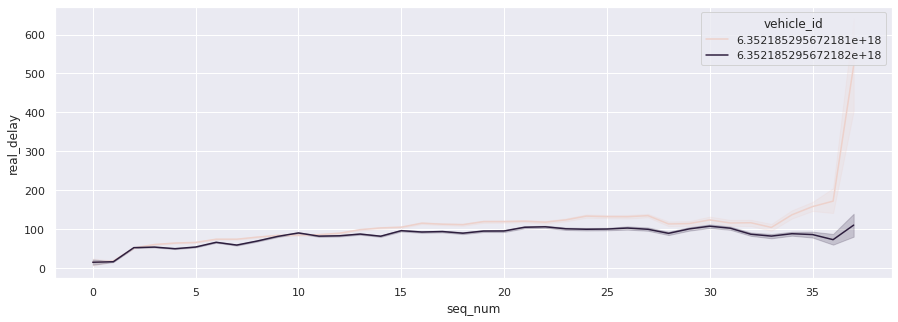

In [271]:
plt.figure(figsize=(15,5)) # один из составов явно на дольше поаздывает, особенно на длинных маршрутах
sns.lineplot(data=my_train, x="seq_num", y="real_delay", hue="vehicle_id")

In [272]:
my_train["delay"].value_counts() # проверяем аутлайеры по времени задержки травмаем

0.0       81698
60.0      49070
120.0     23905
180.0     11536
240.0      5217
300.0      2249
360.0      1039
420.0       548
480.0       294
540.0       197
600.0        97
720.0        46
660.0        40
780.0        30
840.0        18
1140.0        1
960.0         1
Name: delay, dtype: int64

vehicle_id
6.352185e+18    AxesSubplot(0.125,0.125;0.775x0.755)
6.352185e+18    AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

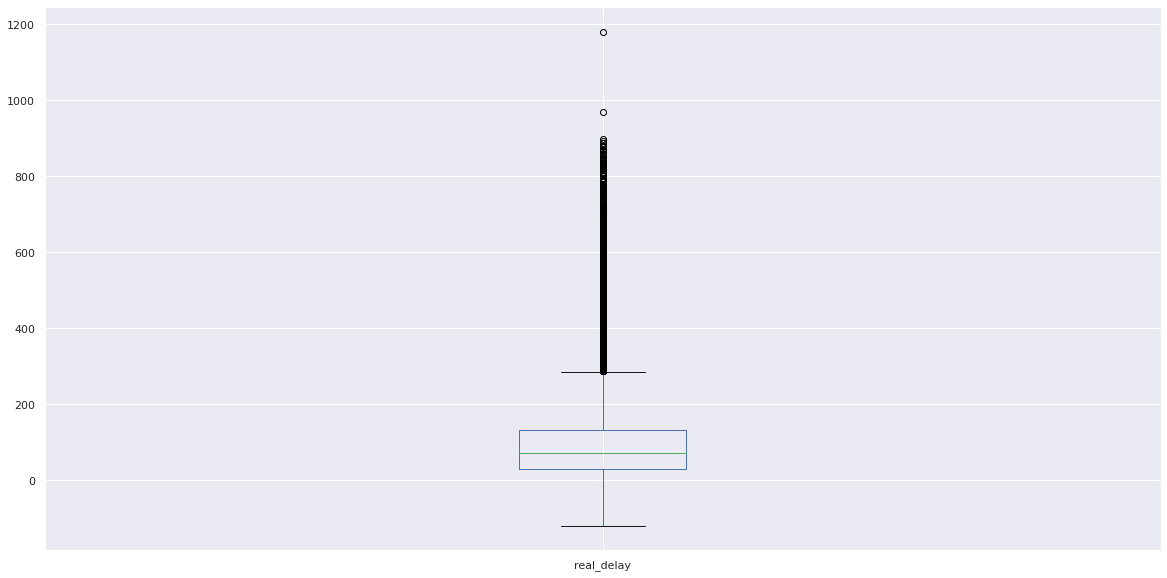

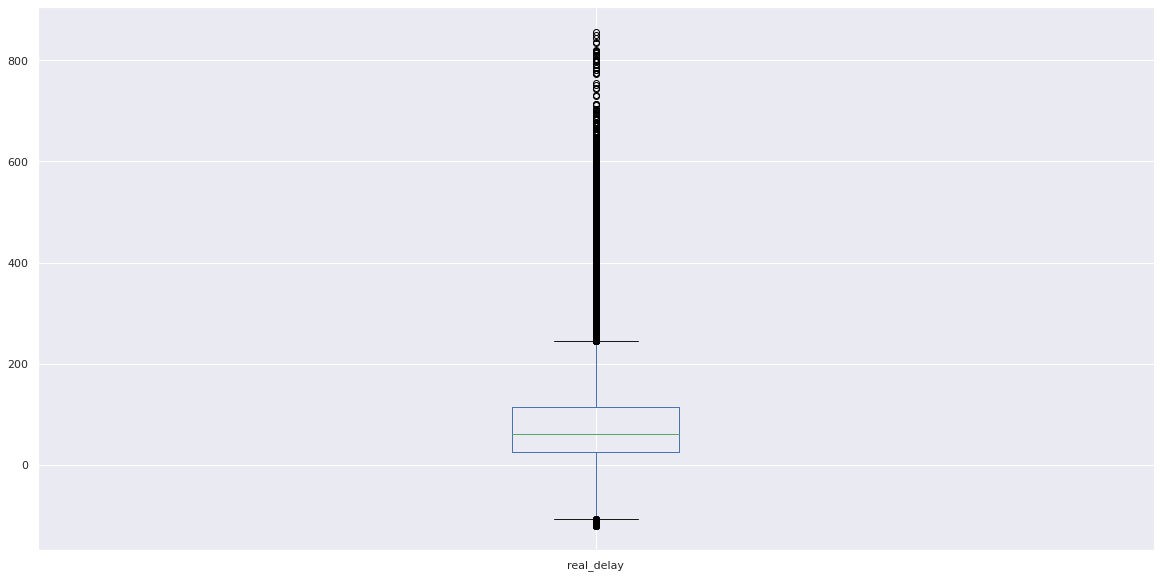

In [273]:
my_train.groupby("vehicle_id").plot(kind = "box", x="vehicle_id", y="real_delay") # малоинформативно, но аутлаеров много

vehicle_id
6.352185e+18    AxesSubplot(0.125,0.125;0.775x0.755)
6.352185e+18    AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

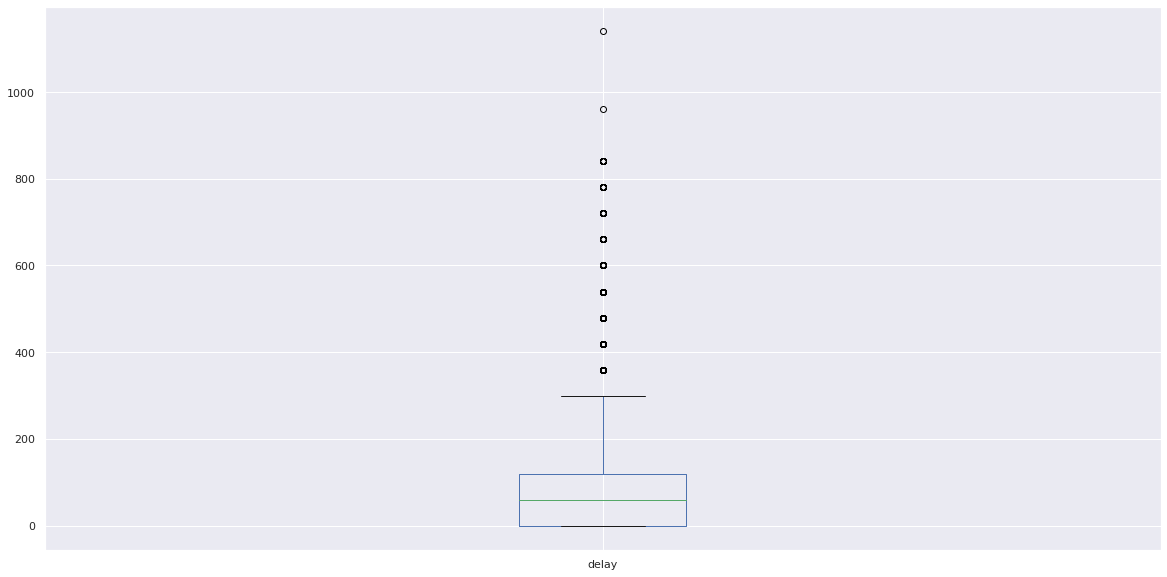

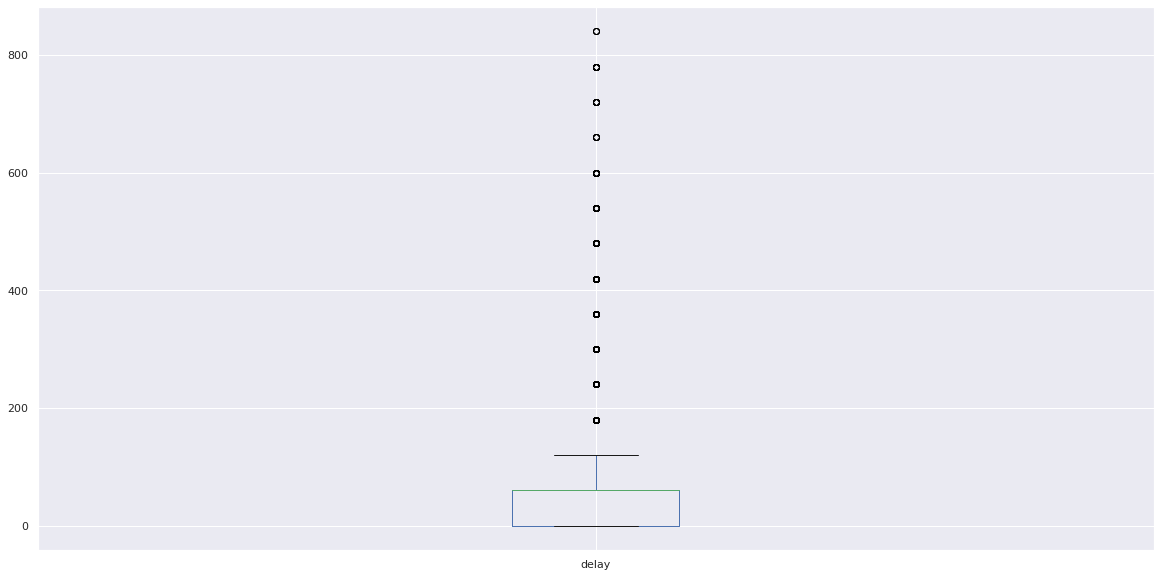

In [274]:
my_train.groupby("vehicle_id").plot(kind = "box", x="vehicle_id", y="delay") # малоинформативно, но аутлаеров много

In [275]:
my_train.groupby(["vehicle_id", "number"]).agg({"seq_num": max, "real_delay": "max"})

seq_num  real_delay
vehicle_id   number                     
6.352185e+18 1          31.0       686.0
             2          11.0       555.0
             5          25.0      1181.0
             6          21.0       687.0
             8          26.0       271.0
             9          35.0       733.0
             10         27.0       751.0
             11         21.0       694.0
             13         27.0       563.0
             14         37.0       969.0
             16         14.0       240.0
             18         25.0       227.0
             19         19.0       734.0
             20         18.0       616.0
             21         11.0       658.0
             22         36.0       810.0
             24         27.0       857.0
             44         24.0       881.0
             50         17.0       373.0
             52         36.0       559.0
             3          23.0       677.0
             4          32.0       819.0
             8          26.0       714.0
             9          33.0       331.0
             13         27.0       607.0
             14         37.0       857.0
             18         25.0       693.0
             19         19.0       703.0
             50         17.0       587.0
             52         36.0       837.0

In [276]:
my_train["planned_time"].dt.date.value_counts() 
#из колонки **planned_time** предполалгаем, что данные в тест и трейн взяты через день, а 28 и 29 не ездил вообще

2018-07-23    47215
2018-07-24    45246
2018-07-30    44504
2018-07-25    44204
2018-07-31    43649
2018-07-26    43270
2018-07-27    40055
2018-08-01        6
2018-07-28        3
Name: planned_time, dtype: int64

In [277]:
my_train["day"] = my_train["planned_time"].dt.day #вытаскаваем данные из planned_time по дням
my_train["weekday"] = my_train["planned_time"].dt.weekday 
my_train["is_weekend"] = my_train.weekday.isin([5,6])

In [278]:
my_train["weekday"].unique() #из колонки **planned_time** трамваи ездят только 4 дня в неделю, остальное ушло в тест

array([0, 2, 4, 1, 3, 5])

In [279]:
my_train["weekday_round"] = my_train["weekday"].replace({4:2, 5:1, 6:0}) #замыкаем в круг дни недели 0-1-2-3-2-1-0

In [280]:
my_train["hour"] = my_train["planned_time"].dt.hour

In [281]:
my_train["hour"].unique() # судя по данным из колонки **planned_time** трамваи ездят с 04:00 до 00:00

array([ 6,  5,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21,
       22, 23,  0,  4])

In [282]:
my_train["hour"].value_counts() # из колонки **planned_time** можем предположить часы пик с 6:00 до 9:00 и с 15:00 до 18:00

15    20145
16    19782
17    19504
7     19042
8     18986
9     18768
18    18405
6     17775
14    17471
11    16998
19    16979
12    16912
13    16859
10    16294
20    14415
21    12195
22    10744
5     10206
23     5122
4      1507
0        43
Name: hour, dtype: int64

<AxesSubplot:ylabel='Frequency'>

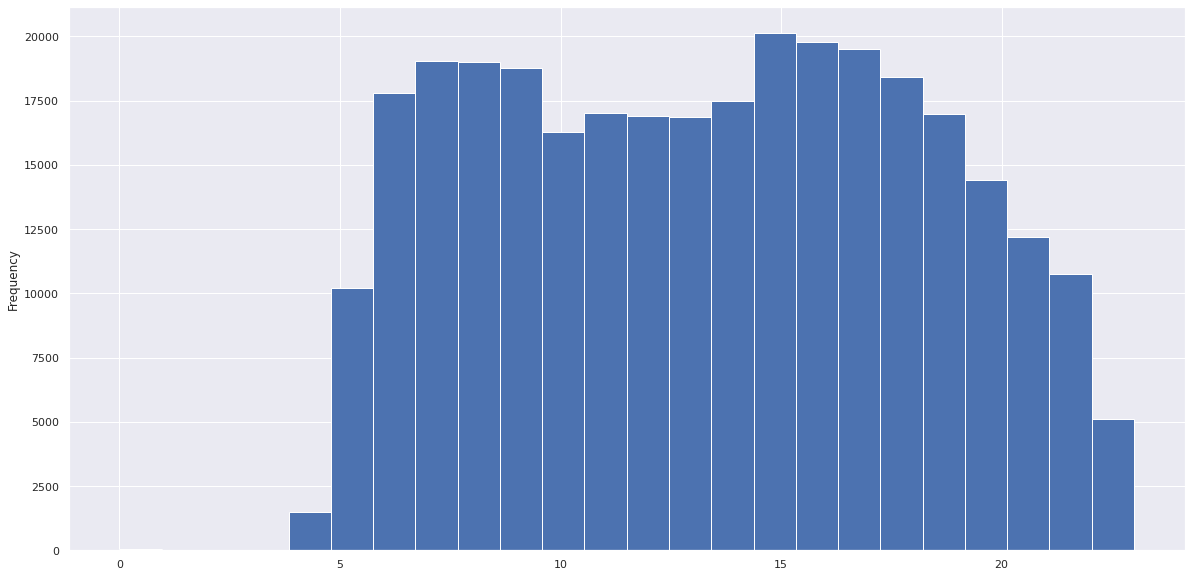

In [283]:
my_train["hour"].plot(kind="hist", bins=24)

In [284]:
my_train["hour_round"] = my_train["hour"].replace({13:11, 14:10, 15:9, 16:8, 17:7, 18:6, 19:5, 20:4, 21:3, 22:2, 23:1})
#замыкаем в круг часы работы 0-1-2-3-4-5-6-7-8-9-10-11-12-11-10-9-8-7-6-5-4-3-2-1-0

In [285]:
my_train.sample(5)

,id,delay,datetime,stop,stop_name,number,direction,planned_time,vehicle_id,trip_id,...,is_delay_neg,is_delay_pos,group_delay,real_seq_num,day,weekday,is_weekend,weekday_round,hour,hour_round
46049,46049,180.0,2018-07-23 22:46:12,409,Centralna,22,Kombinat,2018-07-23 22:43:00,6.352185e+18,6351558574044899599,...,0.0,180.0,180.0,16,23,0,False,0,22,2
70448,70448,NaN,2018-07-24 14:10:42,367,Francesco Nullo,14,Mistrzejowice,2018-07-24 14:09:00,6.352185e+18,6351558574044727817,...,0.0,0.0,NaN,16,24,1,False,1,14,10
82986,82986,NaN,2018-07-24 18:33:52,89,Bronowice,4,Wzgórza K.,2018-07-24 18:33:00,6.352185e+18,6351558574044457485,...,0.0,0.0,NaN,4,24,1,False,1,18,6
260805,260805,0.0,2018-07-30 21:18:35,2691,Chmieleniec,11,Czerwone Maki P+R,2018-07-30 21:19:00,6.352185e+18,6351558574044655637,...,0.0,0.0,0.0,16,30,0,False,0,21,3
151230,151230,NaN,2018-07-26 11:07:25,79,Plac Inwalidów,24,Kurdwanów P+R,2018-07-26 11:06:00,6.352185e+18,6351558574047583239,...,0.0,0.0,NaN,7,26,3,False,3,11,11


## Считаем в секундах расстояние между остановками

In [286]:
my_train.groupby("trip_id").agg({"planned_time":"diff"}) # считаем в пределах одной поездки по trip_id

,planned_time
0,NaT
1,NaT
2,NaT
3,NaT
4,NaT
...,...
308141,00:04:00
308142,00:01:00
308143,00:01:00
308144,00:03:00


In [287]:
# переводим в секунды. в первых остановках нет растояния от предыдущей остановки. заполняем разницу 120 секунд 
my_train["distance_sec"] = my_train.groupby("trip_id").agg({"planned_time":"diff"}).fillna(pd.Timedelta(seconds=120))
my_train["distance_sec"] = my_train["distance_sec"].dt.total_seconds()
my_train["cum_distance_sec"] = my_train.groupby('trip_id')["distance_sec"].cumsum() 

## Создаем дополнительные признаки

In [288]:
# считаем положиительные значения опозданий и было ли опоздание вообще
my_train["real_delay_only"] = my_train["real_delay"].map(lambda x: x if x >= 0 else 0 if pd.notnull(x) else np.NaN)
my_train["is_delay"] = my_train["real_delay"] > 60
my_train.loc[my_train["delay"].isnull(), "is_delay"] = np.NaN
# my_train["is_delay"]

In [289]:
# создаем комбинированные признаки
my_train["number_cat"] = my_train["number"].astype(str)
my_train["number_direction"] = my_train[["number_cat", "direction"]].agg("_".join, axis=1).factorize()[0]

my_train["vehicle_id_cat"] = my_train["vehicle_id"].astype(str)
my_train["number_vehicle_id"] = my_train[["number_cat", "vehicle_id_cat"]].agg("_".join, axis=1).factorize()[0]

my_train["prev_stop_name"] = my_train.groupby("trip_id")["stop_name_cat"].shift(1).fillna(-1)
my_train["prev_stop_name_cat"] = my_train["stop_name_cat"].shift(1).fillna(-1)

my_train["stop_name_str"] = my_train["stop_name"].astype(str)
my_train["stop_name_direction"] = my_train[["stop_name_str", "direction"]].agg("-".join, axis=1).factorize()[0]

my_train["hour_str"] = my_train["hour"].astype(str)
my_train["stop_name_hour"] = my_train[["stop_name", "hour_str"]].agg("-".join, axis=1).factorize()[0]

## Определяем узловые станции-пересечания разных трамвайных направлений

In [290]:
hubs = my_train[["stop_name_cat", "prev_stop_name"]].drop_duplicates()
hubs = hubs.groupby("stop_name_cat").agg({"prev_stop_name":"count"}).reset_index()
hubs.columns = ["stop_name_cat", "hubsize"]
my_train = pd.merge(my_train, hubs, how="left", on="stop_name_cat")

## Считаем вероятность опоздания в разрезе разных параметров

In [291]:
# вероятность опоздания в зависимости от номера маршрута
mx_delay_rate_by_number = my_train.groupby(["number"]).agg({"is_delay":"mean"}).reset_index()
mx_delay_rate_by_number.columns = ["number", "delay_rate_by_number"]
# print(mx_delay_rate_by_number)
my_train = pd.merge(my_train, mx_delay_rate_by_number, how="left", on="number")

In [292]:
# вероятность опоздания в зависимости от времени
mx_delay_rate_by_hour = my_train.groupby(["hour"]).agg({"is_delay":"mean"}).reset_index()
mx_delay_rate_by_hour.columns = ["hour", "delay_rate_by_hour"]
# print(mx_delay_rate_by_hour)
my_train = pd.merge(my_train, mx_delay_rate_by_hour, how="left", on="hour")

In [293]:
# вероятность опоздания в зависимости от остановки
mx_delay_rate_by_stop_name = my_train.groupby(["stop_name_cat"]).agg({"is_delay":"mean"}).reset_index()
mx_delay_rate_by_stop_name.columns = ["stop_name_cat", "delay_rate_by_stop_name_cat"]
# print(mx_delay_rate_by_stop_name)
my_train = pd.merge(my_train, mx_delay_rate_by_stop_name, how="left", on="stop_name_cat")

In [294]:
# вероятность опоздания в зависимости от комбинации остановки и времени
mx_delay_rate_by_stop_name_hour = my_train.groupby(["stop_name_hour"]).agg({"is_delay":"mean"}).reset_index()
mx_delay_rate_by_stop_name_hour.columns = ["stop_name_hour", "delay_rate_by_stop_name_hour"]
# print(mx_delay_rate_by_stop_name_hour)
my_train = pd.merge(my_train, mx_delay_rate_by_stop_name_hour, how="left", on="stop_name_hour")

In [295]:
# вероятность опоздания в зависимости от направления
mx_delay_rate_by_direction = my_train.groupby(["direction"]).agg({"is_delay":"mean"}).reset_index()
mx_delay_rate_by_direction.columns = ["direction", "delay_rate_by_direction"]
# print(mx_delay_rate_by_direction)
my_train = pd.merge(my_train, mx_delay_rate_by_direction, how="left", on="direction")

In [296]:
# вероятность опоздания в зависимости от состава
mx_delay_rate_by_vehicle = my_train.groupby(["vehicle_id_cat"]).agg({"is_delay":"mean"}).reset_index()
mx_delay_rate_by_vehicle.columns = ["vehicle_id_cat", "delay_rate_by_vehicle"]
# print(mx_delay_rate_by_vehicle)
my_train = pd.merge(my_train, mx_delay_rate_by_vehicle, how="left", on="vehicle_id_cat")

In [297]:
# вероятность опоздания в зависимости от комбинации остановки и направления
mx_delay_rate_by_stop_name_direction = my_train.groupby(["stop_name_direction"]).agg({"is_delay":"mean"}).reset_index()
mx_delay_rate_by_stop_name_direction.columns = ["stop_name_direction", "delay_rate_by_stop_name_direction"]
# print(mx_delay_rate_by_stop_name_direction)
my_train = pd.merge(my_train, mx_delay_rate_by_stop_name_direction, how="left", on="stop_name_direction")

## Для получения более сложных комбинаций вероятностей перемножаем уже посчитанные выше комбинированые признаки

In [298]:
my_train["delay_rate_by_number_hour"] = my_train["delay_rate_by_number"] * my_train["delay_rate_by_hour"] 
my_train["delay_rate_by_vehichle_hour"] = my_train["delay_rate_by_vehicle"] * my_train["delay_rate_by_hour"] 
my_train["delay_rate_by_direction_hour"] = my_train["delay_rate_by_direction"] * my_train["delay_rate_by_hour"] 
my_train["delay_rate_by_number_stop_name_hour"] = (my_train["delay_rate_by_number"] 
                                                   * my_train["delay_rate_by_stop_name_cat"] 
                                                   * my_train["delay_rate_by_hour"]) 
my_train["delay_rate_by_number_stop_name_direction_hour"] = (my_train["delay_rate_by_number"] 
                                                             * my_train["delay_rate_by_stop_name_cat"] 
                                                             * my_train["delay_rate_by_direction"] 
                                                             * my_train["delay_rate_by_hour"]) 

## Рассчитываем статистики по опозданиям для разных параметров

In [299]:
my_train_stopname_delay = my_train[["stop_name", "real_delay"]].groupby("stop_name").agg(
    mean_stopname_delay=("real_delay", "mean"),
    median_stopname_delay=("real_delay", "median"),
    count_stopname_delay=("real_delay", "count"),
    std_stopname_delay=("real_delay", "std"),
    count_zeros_stopname_delay=("real_delay", lambda vals: len([x for x in vals if x == 0]) ),
    prob_zeros_stopname_delay=("real_delay", lambda vals: np.mean([x == 0 for x in vals]) ),
).reset_index()

In [300]:
my_train = pd.merge(my_train, my_train_stopname_delay, how='left', on='stop_name')
# my_train_stopname_delay

In [301]:
my_train_hour_delay = my_train[["hour", "real_delay"]].groupby("hour").agg(
    mean_hour_delay=("real_delay", "mean"),
    median_hour_delay=("real_delay", "median"),
    count_hour_delay=("real_delay", "count"),
    std_hour_delay=("real_delay", "std"),
    count_zeros_hour_delay=("real_delay", lambda vals: len([x for x in vals if x == 0]) ),
    prob_zeros_hour_delay=("real_delay", lambda vals: np.mean([x == 0 for x in vals]) ),
).reset_index()
my_train = pd.merge(my_train, my_train_hour_delay, how='left', on='hour')
# my_train_hour_delay

In [302]:
my_train_stop_name_hour_delay = my_train[["stop_name_hour", "real_delay"]].groupby("stop_name_hour").agg(
    mean_stop_name_hour_delay=("real_delay", "mean"),
    median_stop_name_hour_delay=("real_delay", "median"),
    count_stop_name_hour_delay=("real_delay", "count"),
    std_stop_name_hour_delay=("real_delay", "std"),
    count_zeros_stop_name_hour_delay=("real_delay", lambda vals: len([x for x in vals if x == 0]) ),
    prob_zeros_stop_name_hour_delay=("real_delay", lambda vals: np.mean([x == 0 for x in vals]) ),
).reset_index()
my_train = pd.merge(my_train, my_train_stop_name_hour_delay, how="left", on="stop_name_hour")
my_train_stop_name_hour_delay

,stop_name_hour,mean_stop_name_hour_delay,median_stop_name_hour_delay,count_stop_name_hour_delay,std_stop_name_hour_delay,count_zeros_stop_name_hour_delay,prob_zeros_stop_name_hour_delay
0,0,33.574074,19.5,54,61.631162,1.0,0.018519
1,1,84.586777,73.0,121,57.339874,0.0,0.000000
2,2,19.431624,11.0,234,45.731039,8.0,0.034188
3,3,81.859649,72.5,114,62.521342,0.0,0.000000
4,4,72.183099,60.5,142,49.852494,0.0,0.000000
...,...,...,...,...,...,...,...
3041,3041,10.000000,10.0,1,NaN,0.0,0.000000
3042,3042,44.000000,44.0,1,NaN,0.0,0.000000
3043,3043,-7.000000,-7.0,1,NaN,0.0,0.000000
3044,3044,160.000000,160.0,1,NaN,0.0,0.000000


In [303]:
my_train[(my_train["distance_sec"]<0) | (my_train["distance_sec"]>1000)][['delay', 'stop', 'number', 'planned_time', 'seq_num', 'trip_id', 'distance_sec']]

,delay,stop,number,planned_time,seq_num,trip_id,distance_sec
1085,60.0,129,44,2018-07-23 06:24:00,13.0,6351558574044989698,1200.0
2542,60.0,2811,52,2018-07-23 06:54:00,15.0,6351558574045088003,1020.0
3345,120.0,363,1,2018-07-23 07:09:00,24.0,6351558574044354820,1200.0
4203,0.0,2741,6,2018-07-23 07:28:00,16.0,6351558574044526852,1380.0
5462,120.0,1049,8,2018-07-23 07:52:00,22.0,6351558574044592388,2040.0
...,...,...,...,...,...,...,...
307346,NaN,319,6,2018-07-31 22:54:00,19.0,6351558574044524823,1800.0
307843,NaN,129,9,2018-07-31 23:20:00,17.0,6351558574044619025,1140.0
307865,NaN,1049,13,2018-07-31 23:21:00,2.0,6351558574044700948,-2460.0
307956,NaN,681,3,2018-07-31 23:28:00,21.0,6351558574044426519,2160.0


<AxesSubplot:xlabel='delay', ylabel='Count'>

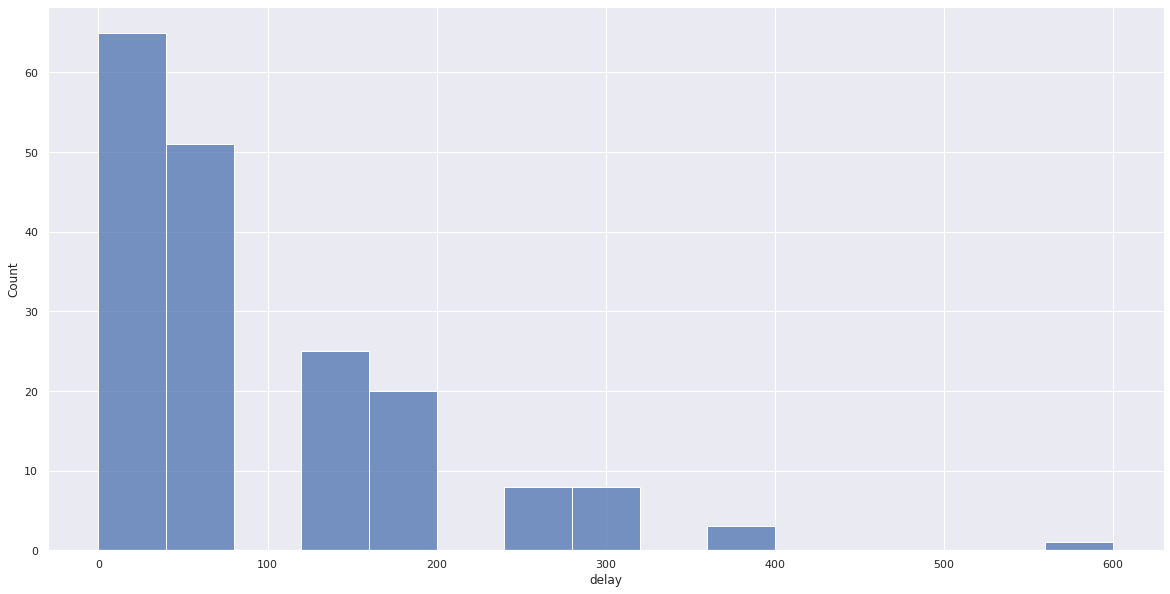

In [304]:
sns.histplot(my_train[my_train["distance_sec"] > 1000].delay, bins=15)

In [305]:
my_train[my_train["trip_id"] == 6351558574044592388][['delay', 'stop', 'number', 'planned_time', 'seq_num', 'trip_id', 'distance_sec']]

,delay,stop,number,planned_time,seq_num,trip_id,distance_sec
3633,0.0,747,8,2018-07-23 07:17:00,1.0,6351558574044592388,120.0
3691,0.0,824,8,2018-07-23 07:18:00,2.0,6351558574044592388,60.0
5462,120.0,1049,8,2018-07-23 07:52:00,22.0,6351558574044592388,2040.0
5680,180.0,133,8,2018-07-23 07:55:00,24.0,6351558574044592388,180.0
5778,180.0,136,8,2018-07-23 07:57:00,25.0,6351558574044592388,120.0


In [306]:
num_feats = my_train.select_dtypes("number").columns.to_list()
black_list = ["id", "delay", "is_delay", "real_delay", "real_delay_only"]
num_feats = [x for x in num_feats if x not in black_list]

In [307]:
def scatter_pairplots(df, x_cols, y_col='real_delay'):
  fig, axes = plt.subplots(nrows=len(num_feats), ncols=1, figsize=(15, 7*len(num_feats)), sharex=False, sharey=False)
  axes = axes.ravel()  

  for col, ax in zip(x_cols, axes):
      data = df[[col, y_col]].reset_index()
      sns.scatterplot(data=data, x=col, y=y_col, ax=ax)
      ax.set(title=f'Relation of Column {y_col} with Column: {col}', xlabel=None)
      
  fig.tight_layout()
  plt.show()

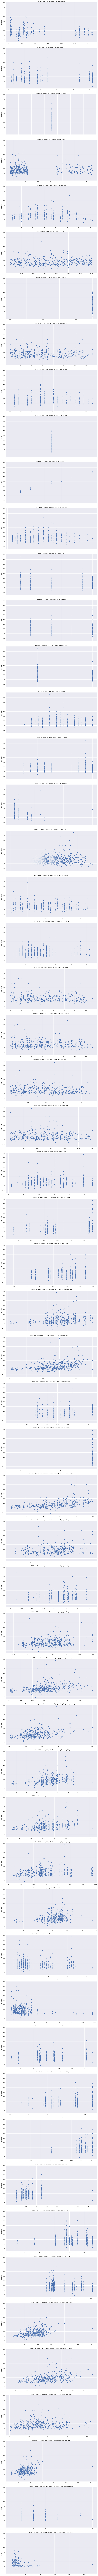

In [308]:
scatter_pairplots(df=my_train.sample(1000), y_col='real_delay', x_cols=num_feats)

## Распеределяем вероятность опоздания по номеру маршрута, направлению, составу, остановкам, времении комбинированным признакам.

In [309]:
# delay_by_number = my_train.groupby(["number"]).agg({"real_delay_is_pos":"mean"}).reset_index()
# delay_by_number.columns = ["number", "delay_by_number"]
# my_train = pd.merge(my_train, delay_by_number, how="left", on="number")

In [310]:
# delay_by_stop_name = my_train.groupby(["stop_name"]).agg({"real_delay_is_pos":"mean"}).reset_index()
# delay_by_stop_name.columns = ["stop_name", "delay_by_stop_name"]
# my_train = pd.merge(my_train, delay_by_stop_name, how="left", on="stop_name")

In [311]:
# delay_by_direction = my_train.groupby(["direction"]).agg({"real_delay_is_pos":"mean"}).reset_index()
# delay_by_direction.columns = ["direction", "delay_by_direction"]
# my_train = pd.merge(my_train, delay_by_direction, how="left", on="direction")

In [312]:
# delay_by_vehicle_id = my_train.groupby(["vehicle_id"]).agg({"real_delay_is_pos":"mean"}).reset_index()
# delay_by_vehicle_id.columns = ["vehicle_id", "delay_by_vehicle_id"]
# my_train = pd.merge(my_train, delay_by_vehicle_id, how="left", on="vehicle_id")

In [313]:
# delay_by_hour = my_train.groupby(["hour"]).agg({"real_delay_is_pos":"mean"}).reset_index()
# delay_by_hour.columns = ["hour", "delay_by_hour"]
# my_train = pd.merge(my_train, delay_by_hour, how="left", on="hour")

## Считаем плотность движения трамваев (пробки)

In [314]:
my_train_tram_density = my_train.groupby('stop_name_hour').agg(tram_density=("id", 'count')).reset_index()
my_train = pd.merge(my_train, my_train_tram_density, how='left', on='stop_name_hour')

In [315]:
my_train_tram_density_by_direction = my_train.groupby(['stop_name_hour', 'direction']).agg(tram_density_by_direction=("id", 'count')).reset_index()
my_train = pd.merge(my_train, my_train_tram_density_by_direction, how='left', on=['stop_name_hour', 'direction'])

In [316]:
## считаем количество одновременных поездок условными пасажирами

In [317]:
my_train_passengers = my_train[my_train.delay.notnull()].groupby(['stop_name','number', 'planned_time']).agg(passengers = ("trip_id", 'count'),
                                                                                           mean_delay = ('real_delay', 'mean')).reset_index()
my_train = pd.merge(my_train, my_train_passengers[['stop_name','number', 'planned_time', 'passengers']], how='left', on=['stop_name','number', 'planned_time'])
# my_train_passengers[my_train_passengers.passengers > 1][my_train_passengers.mean_delay < 1]

In [318]:
my_train_passengers_any = my_train[my_train.delay.notnull()].groupby(['stop_name', 'planned_time']).agg(passengers_any = ("trip_id", 'count'),
                                                                                      mean_delay = ('real_delay', 'mean')).reset_index()
my_train = pd.merge(my_train, my_train_passengers_any[['stop_name', 'planned_time', 'passengers_any']], how='left', on=['stop_name', 'planned_time'])
my_train_passengers_any[my_train_passengers_any.passengers_any > 1]

,stop_name,planned_time,passengers_any,mean_delay
10,AWF,2018-07-23 06:32:00,2,8.5
71,AWF,2018-07-23 09:06:00,2,83.5
78,AWF,2018-07-23 09:26:00,2,18.0
90,AWF,2018-07-23 10:00:00,2,64.0
97,AWF,2018-07-23 10:20:00,2,64.5
...,...,...,...,...
156002,Św.Wawrzyńca,2018-07-30 16:47:00,2,223.5
156009,Św.Wawrzyńca,2018-07-30 17:07:00,2,97.5
156021,Św.Wawrzyńca,2018-07-30 17:47:00,2,145.0
156028,Św.Wawrzyńca,2018-07-30 18:07:00,2,82.0


In [319]:
# ProfileReport(my_train, title="Pandas Profiling Report")

In [320]:
# sns.displot(my_train.real_delay)

## Считаем статистики опоздания для тестовой выборки на основании данных за предыдущий день (тренировочной выборки)

In [321]:
df_train["planned_time"] = pd.to_datetime(df_train["planned_time"])
my_train["planned_time_ymd"] = my_train["planned_time"].map(lambda x: x.strftime("%Y-%m-%d"))

#feature engineering
my_train["planned_time_hour"] = my_train["planned_time"].dt.hour


## group
def df_group_delay(df_train, groupby_feats):
    agg_params = {
        "mean_{}_delay".format("_".join(groupby_feats)): ("delay", "mean"),
        "median_{}_delay".format("_".join(groupby_feats)): ("delay", "median"),
        "count_{}_delay".format("_".join(groupby_feats)): ("delay", "count"),
        "std_{}_delay".format("_".join(groupby_feats)): ("delay", "std"),
        "count_zeros_{}_delay".format("_".join(groupby_feats)): ("delay", lambda vals: len([x for x in vals if x == 0]) ),
        "prob_zeros_{}_delay".format("_".join(groupby_feats)): ("delay", lambda vals: np.mean([x == 0 for x in vals]) ),
    }
    
    return df_train[groupby_feats + ["delay"]].groupby(groupby_feats).agg(
        **agg_params
    ).reset_index()

df_tmp = df_group_delay(df_train, ["stop_name"])
if "mean_stopname_delay" not in my_train:
    df = pd.merge(my_train, df_tmp, on="stop_name", how="left")
    
df_tmp = df_group_delay(df_train, ["stop_name", "direction"])
if "mean_stopname_direction_delay" not in my_train:
    my_train = pd.merge(my_train, df_tmp, on=["stop_name", "direction"], how="left")

In [322]:
def df_group_delay_shift(df_train, groupby_feats, shift):
    df_train["planned_time_{}d".format(shift)] = df_train["planned_time"] + pd.Timedelta(days=shift)
    df_train["planned_time_{}d_hour".format(shift)] = df_train["planned_time_{}d".format(shift)].dt.hour
    df_train["planned_time_{}d_ymd".format(shift)] = df_train["planned_time_{}d".format(shift)].map(lambda x: x.strftime("%Y-%m-%d"))
    
    groupby_feats = ["planned_time_1d_ymd", "planned_time_1d_hour"] + groupby_feats
    
    agg_params = {
        "mean_1d_{}_delay".format("_".join(groupby_feats)): ("delay", "mean"),
        "median_1d_{}_delay".format("_".join(groupby_feats)): ("delay", "median"),
        "count_1d_{}_delay".format("_".join(groupby_feats)): ("delay", "count"),
        "std_1d_{}_delay".format("_".join(groupby_feats)): ("delay", "std"),
        "count_1d_zeros_{}_delay".format("_".join(groupby_feats)): ("delay", lambda vals: len([x for x in vals if x == 0]) ),
        "prob_1d_zeros_{}_delay".format("_".join(groupby_feats)): ("delay", lambda vals: np.mean([x == 0 for x in vals]) ),
    }
    
    return df_train[groupby_feats + ["delay"]].groupby(groupby_feats).agg(
        **agg_params
    ).reset_index()




if "mean_1d_planned_time_1d_ymd_planned_time_1d_hour_number_delay" not in my_train:
    df_tmp = df_group_delay_shift(df_train, ["number"], shift=1)
    
    my_train = pd.merge(my_train, df_tmp, left_on=["planned_time_ymd", "planned_time_hour", "number"]
    , right_on=["planned_time_1d_ymd", "planned_time_1d_hour", "number"]
    , how="left")

if "mean_1d_planned_time_1d_ymd_planned_time_1d_hour_number_direction_delay" not in my_train:
    df_tmp = df_group_delay_shift(df_train, ["number", 'direction'], shift=1)
    
    my_train = pd.merge(my_train, df_tmp, left_on=["planned_time_ymd", "planned_time_hour", "number",'direction']
    , right_on=["planned_time_1d_ymd", "planned_time_1d_hour", "number", 'direction']
    , how="left")

In [323]:
my_train.columns

Index(['id', 'delay', 'datetime', 'stop', 'stop_name', 'number', 'direction',
       'planned_time', 'vehicle_id', 'trip_id', 'seq_num', 'trip_id_cat',
       'vehicle_cat', 'stop_name_cat', 'direction_cat', 'real_delay',
       'real_delay_is_pos', 'is_delay_neg', 'is_delay_pos', 'group_delay',
       'real_seq_num', 'day', 'weekday', 'is_weekend', 'weekday_round', 'hour',
       'hour_round', 'distance_sec', 'cum_distance_sec', 'real_delay_only',
       'is_delay', 'number_cat', 'number_direction', 'vehicle_id_cat',
       'number_vehicle_id', 'prev_stop_name', 'prev_stop_name_cat',
       'stop_name_str', 'stop_name_direction', 'hour_str', 'stop_name_hour',
       'hubsize', 'delay_rate_by_number', 'delay_rate_by_hour',
       'delay_rate_by_stop_name_cat', 'delay_rate_by_stop_name_hour',
       'delay_rate_by_direction', 'delay_rate_by_vehicle',
       'delay_rate_by_stop_name_direction', 'delay_rate_by_number_hour',
       'delay_rate_by_vehichle_hour', 'delay_rate_by_direction_ho

In [324]:
feats = ['stop', 'number', 'seq_num', 'distance_sec',
        'stop_name_cat', 'direction_cat', 'trip_id_cat', 'vehicle_id_cat', 'number_cat',
        'day', 'weekday', 'weekday_round', 'hour', 'hour_round',         
        'number_direction', 'number_vehicle_id', 
        'delay_by_number', 'delay_by_stop_name','delay_by_direction', 'delay_by_vehicle_id','delay_by_hour', 'real_seq_num',
        'cum_distance_sec', 'prev_stop_name', 'hubsize',
        'delay_by_number', 'delay_by_stop_name',
       'delay_by_direction', 'delay_by_vehicle_id', 'delay_by_hour',

       'mean_stop_name_direction_delay', 'median_stop_name_direction_delay',
       'count_stop_name_direction_delay', 'std_stop_name_direction_delay',
       'count_zeros_stop_name_direction_delay',
       'prob_zeros_stop_name_direction_delay', 
       'mean_1d_planned_time_1d_ymd_planned_time_1d_hour_number_delay',
       'median_1d_planned_time_1d_ymd_planned_time_1d_hour_number_delay',
       'count_1d_planned_time_1d_ymd_planned_time_1d_hour_number_delay',
       'std_1d_planned_time_1d_ymd_planned_time_1d_hour_number_delay',
       'count_1d_zeros_planned_time_1d_ymd_planned_time_1d_hour_number_delay',
       'prob_1d_zeros_planned_time_1d_ymd_planned_time_1d_hour_number_delay',
         
        'mean_1d_planned_time_1d_ymd_planned_time_1d_hour_number_direction_delay',
       'median_1d_planned_time_1d_ymd_planned_time_1d_hour_number_direction_delay',
       'count_1d_planned_time_1d_ymd_planned_time_1d_hour_number_direction_delay',
       'std_1d_planned_time_1d_ymd_planned_time_1d_hour_number_direction_delay',
       'count_1d_zeros_planned_time_1d_ymd_planned_time_1d_hour_number_direction_delay',
       'prob_1d_zeros_planned_time_1d_ymd_planned_time_1d_hour_number_direction_delay'
        ]

# Так выглядит целевая переменная real_delay_only

<AxesSubplot:xlabel='real_delay_only', ylabel='Count'>

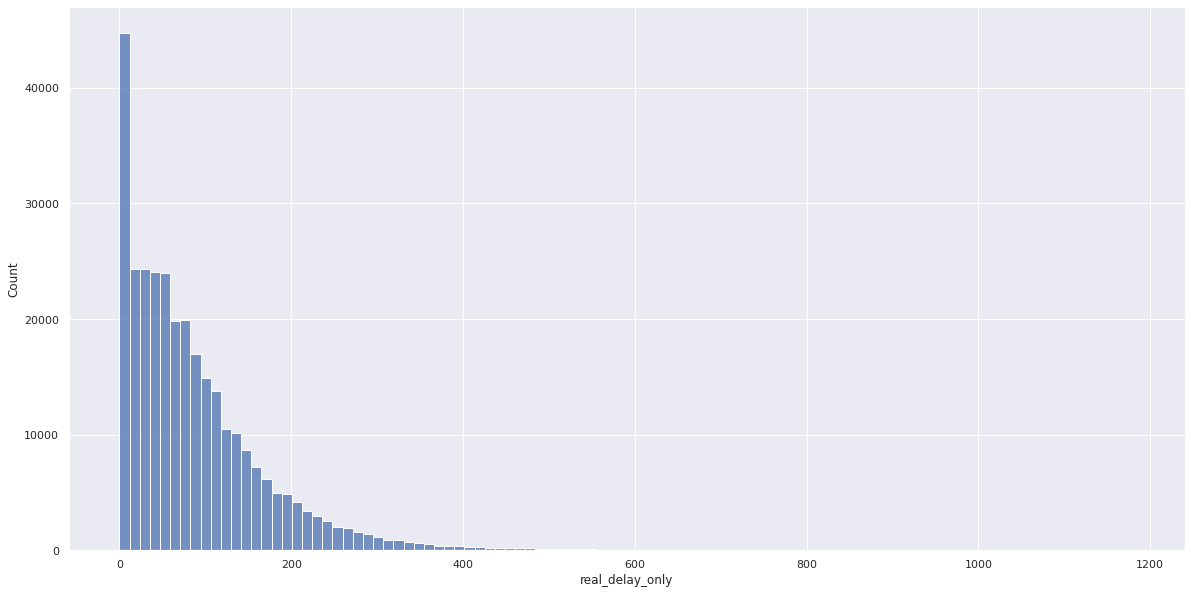

In [325]:
sns.histplot(my_train.real_delay_only, bins=100)

# Обработаем целевую переменную real_delay_only

<AxesSubplot:xlabel='real_delay_only', ylabel='Count'>

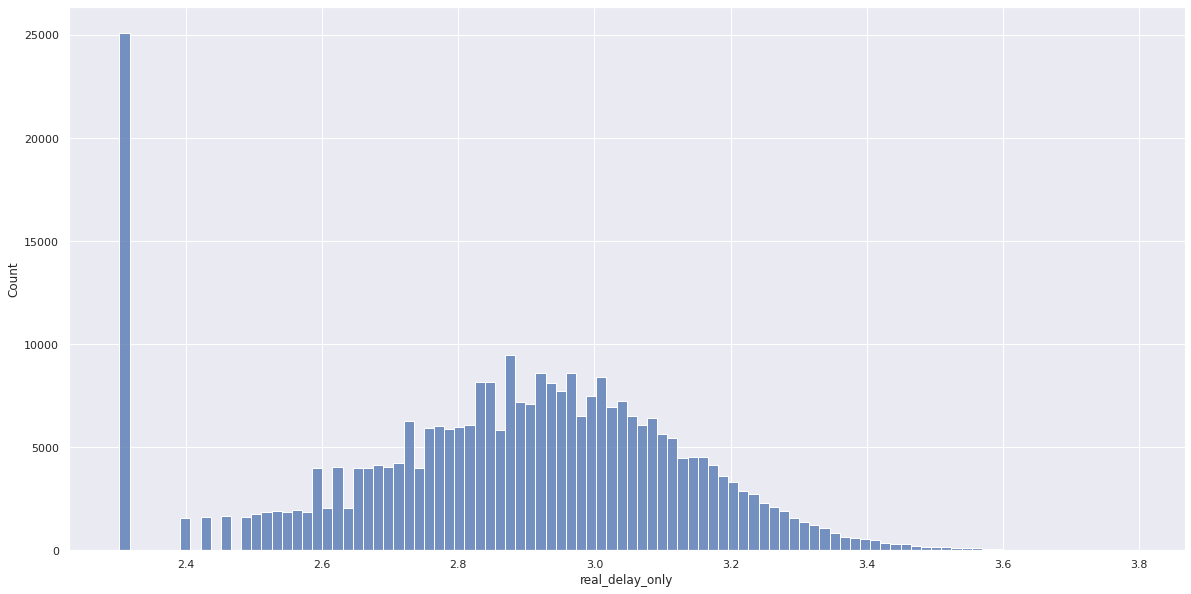

In [326]:
# логарифмируем целевую переменную для получения нормального распределения 
mx = my_train.real_delay_only[my_train.real_delay_only > 0]
sns.histplot(np.log(((my_train.real_delay_only))**(0.5)+10), bins=100)
# эскперементальным метотдом находим константу +10 секунд (что бы избежать логарифмированя 0)

In [328]:
# создадим функции для кодирования и обратного декодирования real_delay_only
def ln_pow_encode(x):
  return np.log(x**(0.5) + 10)

def ln_pow_decode(x):
  return (np.exp((x)) - 10)**2

In [329]:
# создадим логарифмированую версию real_delay_only 
my_train['ln_pow_real_delay'] = my_train.real_delay_only.map(ln_pow_encode)

In [330]:
feats = [
        'stop', 
        'stop_name_cat', 
        'number', 
        'direction_cat',  
        'vehicle_cat', 
        #'trip_cat', 
        'seq_num', 
        #'day', 
        'weekday', 
        'hour', 
        'weekday_round', 
        'is_weekend',
        'hour_round',
        'distance_sec', 
        "number_direction",
        'stop_name_direction',
        "stop_name_hour",
        'real_seq_num',
        "cum_distance_sec",
        'delay_rate_by_number',
        'delay_rate_by_hour',
        'delay_rate_by_stop_name_cat',
        'delay_rate_by_stop_name_hour',
        'delay_rate_by_direction',
        'delay_rate_by_vehicle',
        'delay_rate_by_stop_name_direction',
        'delay_rate_by_number_hour',
        'delay_rate_by_vehichle_hour',
        'delay_rate_by_direction_hour',
        'delay_rate_by_number_stop_name_hour',
        'delay_rate_by_number_stop_name_direction_hour',
        'mean_stopname_delay', 'median_stopname_delay', 'count_stopname_delay', 'std_stopname_delay', 'count_zeros_stopname_delay', 'prob_zeros_stopname_delay',
        'mean_hour_delay', 'median_hour_delay','count_hour_delay','std_hour_delay','count_zeros_hour_delay','prob_zeros_hour_delay',
        'mean_stop_name_hour_delay','median_stop_name_hour_delay','count_stop_name_hour_delay','std_stop_name_hour_delay','count_zeros_stop_name_hour_delay','prob_zeros_stop_name_hour_delay',
        'tram_density',
        'tram_density_by_direction',
        'passengers',
        'passengers_any',
        'mean_stop_name_direction_delay', 'median_stop_name_direction_delay',
        'count_stop_name_direction_delay', 'std_stop_name_direction_delay',
        'count_zeros_stop_name_direction_delay',
        'prob_zeros_stop_name_direction_delay', 
        'mean_1d_planned_time_1d_ymd_planned_time_1d_hour_number_delay',
        'median_1d_planned_time_1d_ymd_planned_time_1d_hour_number_delay',
        'count_1d_planned_time_1d_ymd_planned_time_1d_hour_number_delay',
        'std_1d_planned_time_1d_ymd_planned_time_1d_hour_number_delay',
        'count_1d_zeros_planned_time_1d_ymd_planned_time_1d_hour_number_delay',
        'prob_1d_zeros_planned_time_1d_ymd_planned_time_1d_hour_number_delay',

        'mean_1d_planned_time_1d_ymd_planned_time_1d_hour_number_direction_delay',
        'median_1d_planned_time_1d_ymd_planned_time_1d_hour_number_direction_delay',
        'count_1d_planned_time_1d_ymd_planned_time_1d_hour_number_direction_delay',
        'std_1d_planned_time_1d_ymd_planned_time_1d_hour_number_direction_delay',
        'count_1d_zeros_planned_time_1d_ymd_planned_time_1d_hour_number_direction_delay',
        'prob_1d_zeros_planned_time_1d_ymd_planned_time_1d_hour_number_direction_delay'

         ] 
y_feat = 'ln_pow_real_delay'

In [331]:
df_train = my_train[ my_train["delay"].notnull() ].copy()
df_test = my_train[ my_train["delay"].isnull() ].copy()

X_train = df_train[feats].values
y_train = df_train[y_feat].values
X_test = df_test[feats].values

# Запускаем модель CatBoostRegressor

In [332]:
X_val_train, X_val_test, y_val_train, y_val_test = train_test_split(X_train, y_train, test_size=0.3, random_state=0, stratify = df_train["is_delay"].values)

In [333]:
model_ctb = ctb.CatBoostRegressor(iterations=200, verbose=False, eval_metric='RMSE', max_depth=6)
model_ctb.fit(X_val_train, y_val_train)

y_val_pred = model_ctb.predict(X_val_test)
print(mae(y_val_pred, y_val_test))

y_val_pred_r = ln_pow_decode(y_val_pred)
y_val_test_r = ln_pow_decode(y_val_test)
print(mae(y_val_pred_r, y_val_test_r))

y_val_pred_r[y_val_pred_r < 0] = 0
y_val_pred_r = y_val_pred_r - y_val_pred_r % 60
y_val_test_r = y_val_test_r - y_val_test_r % 60
print(mae(y_val_pred_r, y_val_test_r))


0.15667687230277672
45.2791953023724
41.24630653837412


In [337]:
# проверим важность признаков
feature_importance = pd.DataFrame([feats, model_ctb.feature_importances_]).T
feature_importance.columns = ['feature', 'importance']
feature_importance.sort_values(by=['importance'], axis=0, ascending=False, inplace=True)
# feature_importance

<AxesSubplot:xlabel='feature', ylabel='importance'>

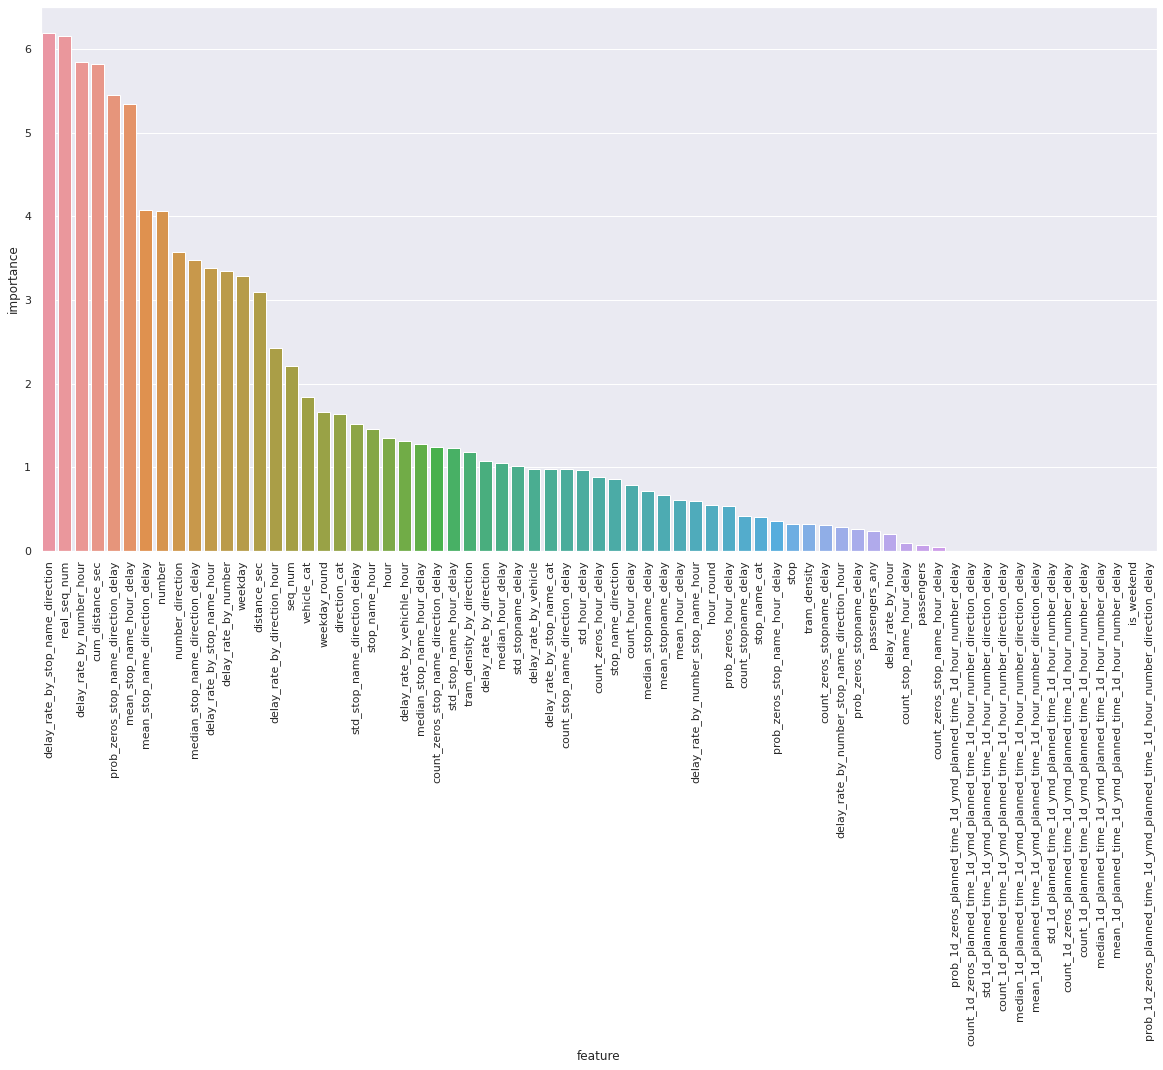

In [336]:
plot_imp = sns.barplot(data=feature_importance, x='feature', y='importance')
plot_imp.set_xticklabels(plot_imp.get_xticklabels(),rotation=90)
plot_imp

# Уберем признаки, у которых важность 0

In [338]:
feats = [
        'stop', 
        'stop_name_cat', 
        'number', 
        'direction_cat',  
        'vehicle_cat', 
        #'trip_cat', 
        'seq_num', 
        #'day', 
        'weekday', 
        'hour', 
        'weekday_round', 
        'is_weekend',
        'hour_round',
        'distance_sec', 
        "number_direction",
        'stop_name_direction',
        "stop_name_hour",
        'real_seq_num',
        "cum_distance_sec",
        'delay_rate_by_number',
        'delay_rate_by_hour',
        'delay_rate_by_stop_name_cat',
        'delay_rate_by_stop_name_hour',
        'delay_rate_by_direction',
        'delay_rate_by_vehicle',
        'delay_rate_by_stop_name_direction',
        'delay_rate_by_number_hour',
        'delay_rate_by_vehichle_hour',
        'delay_rate_by_direction_hour',
        'delay_rate_by_number_stop_name_hour',
        'delay_rate_by_number_stop_name_direction_hour',
        'mean_stopname_delay', 'median_stopname_delay', 'count_stopname_delay', 'std_stopname_delay', 'count_zeros_stopname_delay', 'prob_zeros_stopname_delay',
        'mean_hour_delay', 'median_hour_delay','count_hour_delay','std_hour_delay','count_zeros_hour_delay','prob_zeros_hour_delay',
        'mean_stop_name_hour_delay','median_stop_name_hour_delay','count_stop_name_hour_delay','std_stop_name_hour_delay','count_zeros_stop_name_hour_delay','prob_zeros_stop_name_hour_delay',
        'tram_density',
        'tram_density_by_direction',
        'passengers',
        'passengers_any',
        'mean_stop_name_direction_delay', 'median_stop_name_direction_delay',
        'count_stop_name_direction_delay', 'std_stop_name_direction_delay',
        'count_zeros_stop_name_direction_delay',
        'prob_zeros_stop_name_direction_delay', 
#         'mean_1d_planned_time_1d_ymd_planned_time_1d_hour_number_delay',
#         'median_1d_planned_time_1d_ymd_planned_time_1d_hour_number_delay',
#         'count_1d_planned_time_1d_ymd_planned_time_1d_hour_number_delay',
#         'std_1d_planned_time_1d_ymd_planned_time_1d_hour_number_delay',
#         'count_1d_zeros_planned_time_1d_ymd_planned_time_1d_hour_number_delay',
#         'prob_1d_zeros_planned_time_1d_ymd_planned_time_1d_hour_number_delay',

#         'mean_1d_planned_time_1d_ymd_planned_time_1d_hour_number_direction_delay',
#         'median_1d_planned_time_1d_ymd_planned_time_1d_hour_number_direction_delay',
#         'count_1d_planned_time_1d_ymd_planned_time_1d_hour_number_direction_delay',
#         'std_1d_planned_time_1d_ymd_planned_time_1d_hour_number_direction_delay',
#         'count_1d_zeros_planned_time_1d_ymd_planned_time_1d_hour_number_direction_delay',
#         'prob_1d_zeros_planned_time_1d_ymd_planned_time_1d_hour_number_direction_delay'

         ] 
y_feat = 'ln_pow_real_delay'

In [339]:
df_train = my_train[ my_train["delay"].notnull() ].copy()
df_test = my_train[ my_train["delay"].isnull() ].copy()

X_train = df_train[feats].values
y_train = df_train[y_feat].values
X_test = df_test[feats].values

In [340]:
X_val_train, X_val_test, y_val_train, y_val_test = train_test_split(X_train, y_train, test_size=0.3, random_state=0, stratify = df_train["is_delay"].values)

In [341]:
model_ctb = ctb.CatBoostRegressor(iterations=200, verbose=False, eval_metric='RMSE', max_depth=6)
model_ctb.fit(X_val_train, y_val_train)

y_val_pred = model_ctb.predict(X_val_test)
print(mae(y_val_pred, y_val_test))

y_val_pred_r = ln_pow_decode(y_val_pred)
y_val_test_r = ln_pow_decode(y_val_test)
print(mae(y_val_pred_r, y_val_test_r))

y_val_pred_r[y_val_pred_r < 0] = 0
y_val_pred_r = y_val_pred_r - y_val_pred_r % 60
y_val_test_r = y_val_test_r - y_val_test_r % 60
print(mae(y_val_pred_r, y_val_test_r))


0.15645943140335353
45.23399346533791
41.22585044321539


# Как видно, качество модели не изменилось после удаления признаков

In [343]:
y_pred = model_ctb.predict(X_test)
y_pred[y_pred <0] = 0
y_pred_r = y_pred - y_pred % 60

df_test ["delay"] = y_pred_r

# Сохраняем результаты CatBoostRegressor

In [ ]:
# !mkdir -p ../output

In [ ]:
df_test[ ["id", "delay"] ].to_csv('../output/model_ctb_20_21.10.31_12_00.csv', index=False) 

# Запускаем модель XGBRegressor

In [ ]:
# model_xgb = xgb.XGBRegressor(max_depth=5, n_estimators=50, random_state=0)
# scores = cross_val_score(model_xgb, X_train, y_train, cv=3, scoring="neg_mean_absolute_error")
# np.mean(scores), np.std(scores)

In [ ]:
# model = xgb.XGBRegressor(max_depth=5, n_estimators=50, random_state=0)
# model.fit(X_val_train, y_val_train)
# my_test["delay"] = model.predict(X_val_test)

# Сохраняем результаты XGBRegressor

In [ ]:
# my_test[ ["id", "delay"] ].to_csv('../output/model_xgboost_10.csv', index=False) 

# Запускаем модель RandomForestRegressor

In [ ]:
# model_rf = RandomForestRegressor(n_estimators=500, max_depth=15, min_samples_split=50, min_samples_leaf=10)
# model_rf.fit(X_val_train, y_val_train)

# y_val_pred = model_rf.predict(X_val_test)
# print(mae(y_val_pred, y_val_test))

# y_val_pred[y_val_pred < 0] = 0
# y_val_pred_r = y_val_pred - y_val_pred % 60
# y_val_test_r = y_val_test - y_val_test % 60
# print(mae(y_val_pred_r, y_val_test_r))


In [ ]:
# y_pred = model_rf.predict(X_test)

# y_pred_r = y_pred - y_pred % 60

# df_test ["delay"] = y_pred_r

# Сохраняем результаты RandomForestRegressor

In [ ]:
# df_test[ ["id", "delay"] ].to_csv('../output/model_rf_10.csv', index=False) 

# Запускаем модель RandomForestClassifier

In [ ]:
# df_train = my_train[ my_train["delay"].notnull() ].copy()
# df_test = my_train[ my_train["delay"].isnull() ].copy()

# X_train_clf = df_train[feats].values
# y_train_clf = df_train["delay"].values
# X_test_clf = df_test[feats].values

In [ ]:
# X_clf_train, X_clf_test, y_clf_train, y_clf_test = train_test_split(X_train_clf, y_train_clf, test_size=0.3, random_state=0, stratify = df_train["delay"].values)

In [ ]:
# X_test_clf 

In [ ]:
# df_test.shape

In [ ]:
# model_rf_clf = RandomForestClassifier(n_estimators=500, max_depth=15, min_samples_split=50, min_samples_leaf=10)
# model_rf_clf.fit(X_clf_train, y_clf_train)

# y_clf_pred = model_rf_clf.predict(X_clf_test)
# print(mae(y_clf_pred, y_clf_test))

# y_clf_pred[y_clf_pred < 0] = 0
# y_clf_pred_r = y_clf_pred - y_clf_pred % 60
# y_clf_test_r = y_clf_test - y_clf_test % 60
# print(mae(y_clf_pred_r, y_clf_test_r))


In [ ]:
# y_pred_clf = model_rf_clf.predict(X_test_clf)



# df_test ["delay"] = y_pred_clf

In [ ]:
# y_pred_clf.shape

In [ ]:
# df_test[ ["id", "delay"] ].to_csv('../output/model_rf_clf_10.csv', index=False) 

In [ ]:
# my_train.planned_time.dt.date.unique()

In [ ]:
def get_feats(df):
    feats = df.select_dtypes(include=[int, float]).columns 
    return feats[ (feats != "real_delay") 
                 & (feats != "datetime") 
                 & (feats != "delay") 
                 & (feats != "id") 
                ].values


def get_X(df):
    feats = get_feats(df)
    return df[ get_feats(df) ].values

def get_y(df, target_var='real_delay'):
    return df[target_var].values

def plot_learning_curve(model, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5), target_log=False):
    
    plt.figure(figsize=(12,8))
    plt.title(title)
    if ylim is not None:plt.ylim(*ylim)

    plt.xlabel("Training examples")
    plt.ylabel("Score")
    
    if target_log:
        y = np.log(y)
    
    def my_scorer(model, X, y):
        y_pred = model.predict(X)
        
        if target_log:
            y = np.exp(y)
            y_pred = np.exp(y_pred)
            y_pred[ y_pred<0 ] = 0
        
        return mae(y, y_pred)

        
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring=my_scorer)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


def run_cv(model, X, y, folds=4, target_log=False, cv_type=KFold, success_metric=mae):
    cv = cv_type(n_splits=folds)
    
    scores = []
    for train_idx, test_idx in cv.split(X):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        if target_log:
            y_train = np.log(y_train)

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        if target_log:
            y_pred = np.exp(y_pred)
        
        y_pred[y_pred < 0] = 0 #иногда может быть отрицательное значение

        score = success_metric(y_test, y_pred)
        scores.append( score )
        
    return np.mean(scores), np.std(scores)


def run(X, y, plot_lc=False, folds=3, ylim=(0,100), target_log=False):
#     X, y  = get_X(train), get_y(train)

    for model_name, model in get_models():
        score_mean, score_std = run_cv(model, X, y, folds=folds, target_log=target_log)
        print("[{0}]: {1} +/-{2}".format(model_name, score_mean, score_std))
        sys.stdout.flush() #выводим результат сразу, без кэширования

        if False == plot_lc: continue
        plt = plot_learning_curve(model, model_name, X, y, ylim=ylim, cv=folds, target_log=target_log)
        plt.show()
        


In [ ]:
def get_models():
    return [
#         ('dt-5md', DecisionTreeRegressor(max_depth=30, min_samples_split=30, min_samples_leaf=10, random_state=0)),
        ("ctb", ctb.CatBoostRegressor(iterations=200, verbose=False, eval_metric='MAE', loss_function='RMSE', max_depth=6)),
#         ("xgb", xgb.XGBRegressor(max_depth=6, n_estimators=200, random_state=0)),
#         ("rf", RandomForestClassifier(n_estimators=200, max_depth=15, min_samples_split=50, min_samples_leaf=10)),
#         ("ext-tr", ExtraTreesRegressor(n_estimators=50, max_depth=6, min_samples_split=50, min_samples_leaf=20))
    ]

run(X_train, y_train, plot_lc=True, target_log=False, folds=5)

In [ ]:
# eli5.show_weights(model, feature_names=feats)